# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from keras.layers import Dense
import xgboost as xgb
import statsmodels.api as sm
from itertools import product
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Reading Data Files

In [ ]:
pm = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\Total Surface Mass Concentration - PM 2.5 monthly 0.5 x 0.625.nc')

# Data Preprocessing

## PM2.5 Data

In [ ]:
pm = pm.to_dataframe()

In [ ]:
pm.reset_index(drop = True, inplace = True)
pm = pm.drop('datamonth', axis = 1)
pm = pm[::2]
pm = pm.rename(columns = {'M2TMNXAER_5_12_4_TOTSMASS25' : 'pm2.5', 'time_bnds' : 'time'})
pm.set_index('time', inplace = True)
pm = pd.DataFrame(pm[:247])
pm['pm2.5'] = pm['pm2.5'] * 10 ** 9

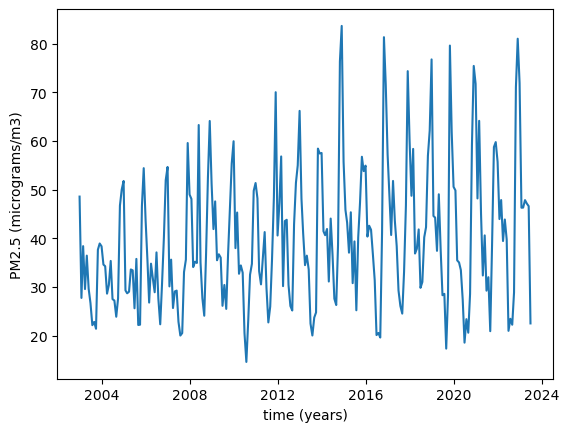

In [ ]:
plt.plot(pm['pm2.5'])
plt.xlabel('time (years)')
plt.ylabel('PM2.5 (micrograms/m3)');

In [ ]:
pm.describe()

,pm2.5
count,247.000000
mean,39.845845
std,14.080724
min,14.617299
25%,29.176561
50%,37.063396
75%,47.985915
max,83.646151


## PM Components

In [ ]:
#sea_salt = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\sea_salt.nc')
black = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\black.nc')
so4 = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\so4.nc')
organic_carbon = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\organic_carbon.nc')
dust_pm25 = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\dust_pm2.5.nc')
so2_surface = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\pm2.5\so2_surface.nc')

In [ ]:
#pm['sea_salt'] = sea_salt['M2TMNXAER_5_12_4_SSSMASS25']
pm['black'] = black['M2TMNXAER_5_12_4_BCSMASS']
pm['so4'] = so4['M2TMNXAER_5_12_4_SO4SMASS']
pm['organic_carbon'] = organic_carbon['M2TMNXAER_5_12_4_OCSMASS']
pm['dust_pm2.5'] = dust_pm25['M2TMNXAER_5_12_4_DUSMASS25']
pm['so2_surface'] = so2_surface['M2TMNXAER_5_12_4_SO2SMASS']

In [ ]:
pm

,pm2.5,black,so4,organic_carbon,dust_pm2.5,so2_surface
time,,,,,,
2003-01-01,48.582850,3.598833e-09,1.572540e-08,1.468232e-08,8.976762e-09,1.024744e-08
2003-02-01,27.766492,1.431753e-09,7.456958e-09,6.271535e-09,7.284347e-09,5.470238e-09
2003-03-01,38.404126,1.096254e-09,5.619780e-09,5.890823e-09,1.810284e-08,3.855496e-09
2003-04-01,29.583028,5.335237e-10,2.474460e-09,3.355443e-09,1.063758e-08,3.374803e-09
2003-05-01,36.456843,4.449924e-10,1.790160e-09,2.162391e-09,1.599538e-08,3.203056e-09
...,...,...,...,...,...,...
2023-03-01,46.321432,1.963430e-09,1.244840e-08,1.457706e-08,5.301873e-09,7.115804e-09
2023-04-01,47.857254,2.023119e-09,1.085682e-08,1.965591e-08,5.269273e-09,7.000765e-09
2023-05-01,47.158392,1.031814e-09,7.951405e-09,5.586558e-09,1.659307e-08,5.675284e-09


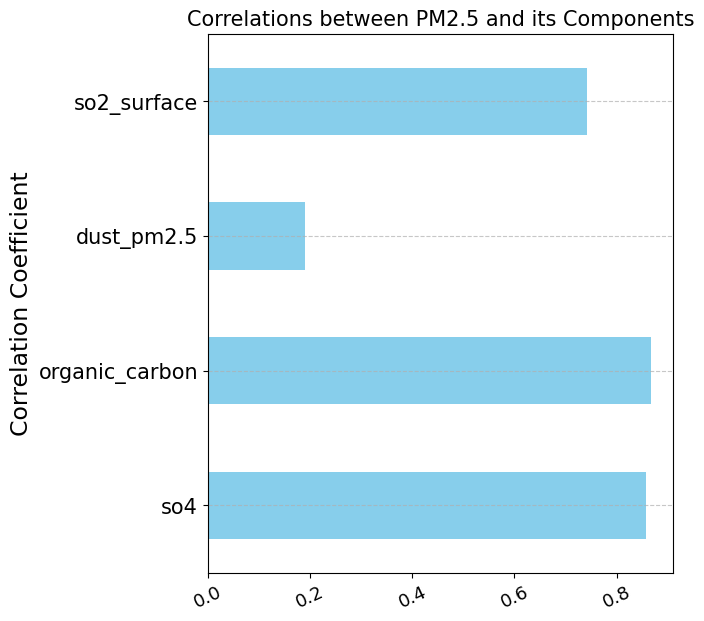

In [ ]:
correlations = pm.corr()['pm2.5'].drop(['pm2.5', 'black'])
plt.figure(figsize=(6, 7))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlations between PM2.5 and its Components', fontsize = 15)
plt.ylabel('Correlation Coefficient', fontsize = 17)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=25, fontsize=13)
plt.yticks(fontsize=15)
plt.show()

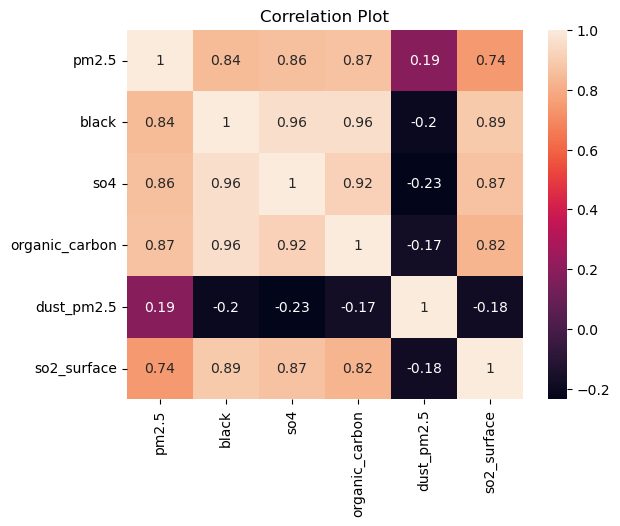

In [ ]:
sns.heatmap(pm.corr(), annot = True)
plt.title('Correlation Plot');

In [ ]:
vif = pd.DataFrame()
vif['variables'] = pm.drop(['pm2.5', 'black'], axis = 1).columns
vif['values'] = [VIF(pm.drop(['pm2.5', 'black'], axis = 1).values, i) for i in range(pm.drop(['pm2.5', 'black'], axis = 1).shape[1])]
vif

,variables,values
0,so4,21.257183
1,organic_carbon,17.467511
2,dust_pm2.5,3.212810
3,so2_surface,15.410574


In [ ]:
X = pm[pm.index < '2015-12-01']

In [ ]:
xtrain, xtest, ytrain, ytest = TTS(X.drop(['pm2.5', 'black'], axis = 1), X['pm2.5'], shuffle = False, test_size = 0.1)

In [ ]:
models = [
    ('Linear Regression', LinearRegression()),
    #('Random Forest', RandomForestRegressor(n_estimators=50)),
    #('Decision Tree', DecisionTreeRegressor())
]

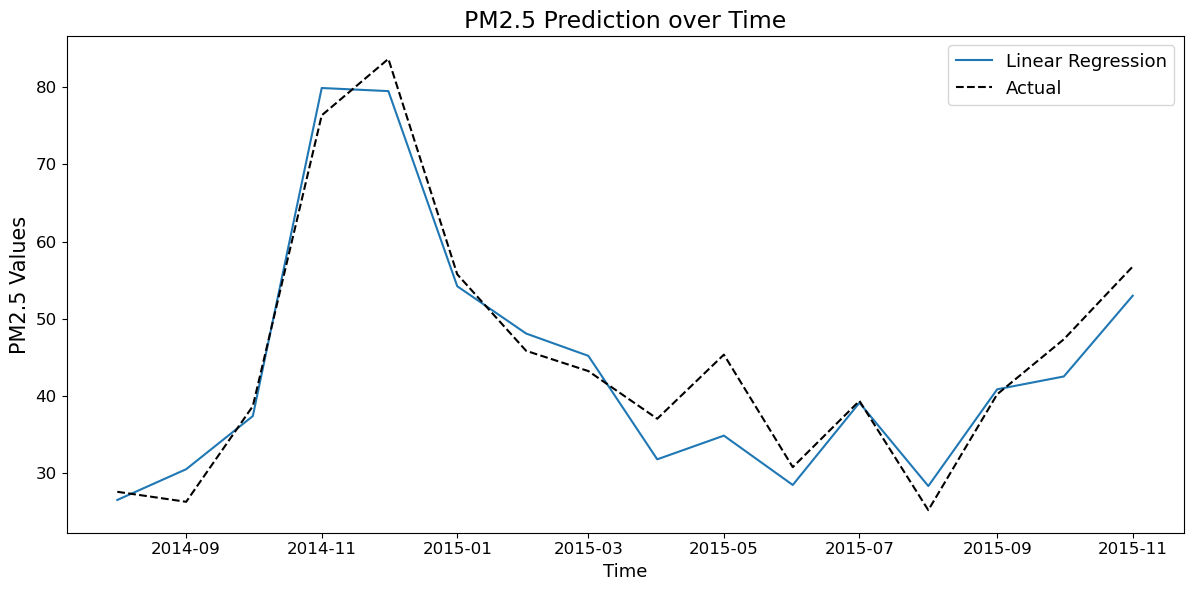

Linear Regression: Train RMSE=3.4381, Test RMSE=3.9711


In [ ]:
time_series = xtest.index
train_mse = []
test_mse = []
model_predictions = {}

for name, model in models:
    if name == 'Deep Learning':
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)
    else:
        model.fit(xtrain, ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_error = MSE(ytrain, y_train_pred) ** (1/2)
    test_error = MSE(ytest, y_test_pred) ** (1/2)

    train_mse.append(train_error)
    test_mse.append(test_error)

    model_predictions[name] = y_test_pred

plt.figure(figsize=(12, 6))
for name, y_pred in model_predictions.items():
    plt.plot(time_series, y_pred, label=name)
plt.plot(time_series, ytest, label='Actual', linestyle='--', color='black')  # Actual data
plt.xlabel('Time', fontsize = 13)
plt.ylabel('PM2.5 Values', fontsize = 15)
plt.title('PM2.5 Prediction over Time', fontsize = 17)
plt.legend(fontsize = 13)
plt.tight_layout()
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

for name, train_err, test_err in zip([model[0] for model in models], train_mse, test_mse):
    print(f'{name}: Train RMSE={train_err:.4f}, Test RMSE={test_err:.4f}')

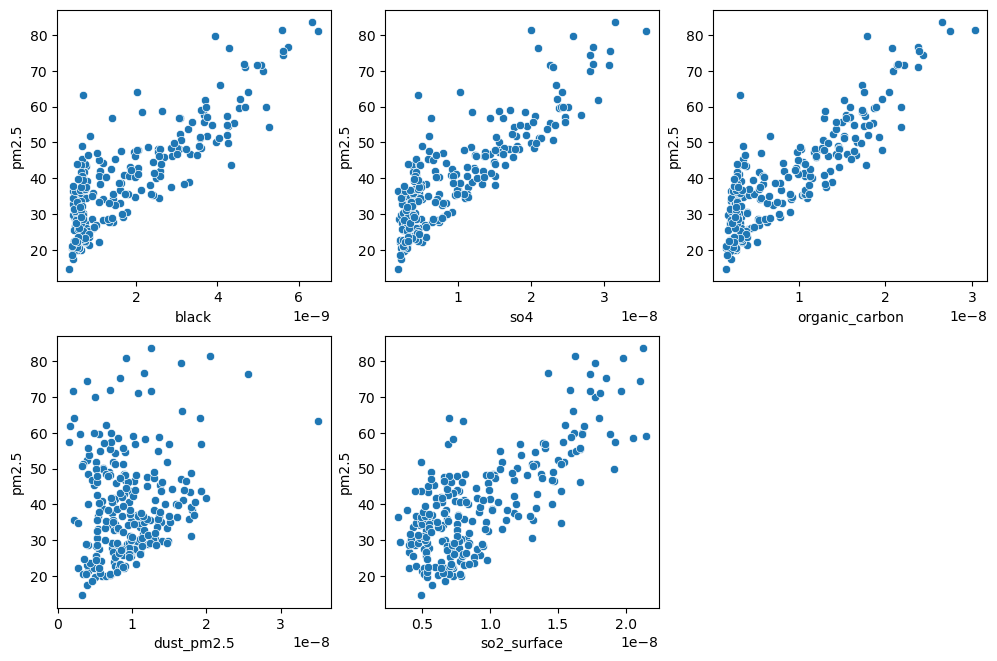

In [ ]:
j = 1
plt.figure(figsize = (12,12))
for i in pm.drop('pm2.5', axis = 1).columns :
    plt.subplot(3,3,j)
    j += 1
    sns.scatterplot(x = pm[i], y = pm['pm2.5'])

In [ ]:
pm['month'] = pm.index.month

In [ ]:
sns.scatterplot(
    x=(pm['sea_salt'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]),
    y=pm['pm2.5'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]
    )
plt.title('Monsoon');

KeyError: 'sea_salt'

In [ ]:
sns.scatterplot(
    x=pm['sea_salt'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)],
    y=pm['pm2.5'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)]
    )
plt.title('Post-monsoon');

In [ ]:
sns.scatterplot(
    x=pm['sea_salt'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)],
    y=pm['pm2.5'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)]
    )
plt.title('Pre-monsoon');

In [ ]:
pm[(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)].corr()

In [ ]:
j = 1
plt.figure(figsize = (12,12))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(3,3,j)
    j += 1
    sns.scatterplot(
    x=pm[i][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)],
    y=pm['pm2.5'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]
    )
plt.suptitle('Jun-Jul-Aug-Sept')
plt.tight_layout();

In [ ]:
j = 1
plt.figure(figsize = (12,12))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(3,3,j)
    j += 1
    sns.scatterplot(
    x=pm[i][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)],
    y=pm['pm2.5'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)]
    )
plt.suptitle('Dec-Jan-Feb')
plt.tight_layout();

In [ ]:
j = 1
plt.figure(figsize = (12,12))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(3,3,j)
    j += 1
    sns.scatterplot(
    x=pm[i][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)],
    y=pm['pm2.5'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)]
    )
plt.suptitle('Mar-Apr-May')
plt.tight_layout();

In [ ]:
pm = pm.drop('month', axis = 1)

In [ ]:
lreg = LinearRegression()

In [ ]:
lreg.fit(xtrain, ytrain)

In [ ]:
pred = lreg.predict(xtest)

In [ ]:
sns.scatterplot(x = pred, y = ytest)
plt.title('Predicted vs ytest (PM2.5 Components)')
plt.xlabel('PM2.5')
plt.ylabel('PM2.5');

In [ ]:
plots = pd.DataFrame()

In [ ]:
plots['pred'] = pred
plots['time'] = pm.index[pm.index > '2019-05-01']
plots.set_index('time', inplace = True)

In [ ]:
plt.plot(pm['pm2.5'][pm.index < '2019-05-01'])
plt.plot(plots['pred'])
plt.xlabel('time (years)')
plt.ylabel('PM2.5 (micrograms/m2)')
plt.title('Train/Test (PM2.5 components)');

In [ ]:
MSE(pred, ytest)

In [ ]:
lreg.score(xtest, ytest)

## Meteorological Data

In [ ]:
air_2m_temp = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\2m_air_temp.nc')
#tot_latent_flux = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\tot_latent_flux.nc')
tot_surf_precip = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\tot_surf_precip.nc')
b_layer = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\era_b_layer.nc')
rel_hum = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\rel_hum_surf.nc')
#specific_hum_2m = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\specific_hum_2m.nc')
#vert_press_velocity = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\vert_press_velocity.nc')
#geopotential_ht = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\geopotential_ht.nc')
wind = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\surf_wind_speed.nc')
#wind = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\u_v_wind_10m.nc')

In [ ]:
b_layer = b_layer.to_dataframe()
b_layer.reset_index(drop = True, inplace = True)
#wind = wind.to_dataframe()
#wind.reset_index(drop = True, inplace = True)

In [ ]:
pm = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\Total Surface Mass Concentration - PM 2.5 monthly 0.5 x 0.625.nc')
pm = pm.to_dataframe()
pm.reset_index(drop = True, inplace = True)
pm = pm.drop('datamonth', axis = 1)
pm = pm[::2]
pm = pm.rename(columns = {'M2TMNXAER_5_12_4_TOTSMASS25' : 'pm2.5', 'time_bnds' : 'time'})
pm.set_index('time', inplace = True)
pm = pd.DataFrame(pm[:247])
pm['pm2.5'] = pm['pm2.5'] * 10 ** 9

In [ ]:
pm['air_temperature'] = air_2m_temp['M2TMNXSLV_5_12_4_T2M'].values - 273.15
#pm['tot_latent_flux'] = tot_latent_flux['M2TMNXFLX_5_12_4_EFLUX']
pm['surface_precipitation'] = tot_surf_precip['M2TMNXFLX_5_12_4_PRECTOT']
pm['wind'] = wind['M2TMNXFLX_5_12_4_SPEED']
pm['boundary_layer_ht'] = np.nan
pm['boundary_layer_ht'] = np.array(b_layer['blh'][:247])
pm['boundary_layer_ht'][-1] = 512.838379
#pm['u_wind'] = np.nan
#pm['u_wind'] = np.array(wind['u10'][:247])
#pm['u_wind'][-1] = -0.009526
#pm['v_wind'] = np.nan
#pm['v_wind'] = np.array(wind['v10'][:247])
#pm['v_wind'][-1] = 1.871388
pm['relative_humidity'] = rel_hum['AIRS3STM_7_0_RelHumSurf_A'].values
#pm['sp_hum_2m'] = specific_hum_2m['FLDAS_NOAH01_C_GL_M_001_Qair_f_tavg'].values
#pm['vert_press_velocity'] = vert_press_velocity['M2IMNPASM_5_12_4_OMEGA'].values
#pm['geopotential_ht'] = geopotential_ht['M2IMNPANA_5_12_4_H'].values

In [ ]:
# knn_imputer = KNNImputer(n_neighbors=2)
# pm['vert_press_velocity'] = knn_imputer.fit_transform(np.array(pm['vert_press_velocity']).reshape(-1,1))
# pm

In [ ]:
pm.columns

Index(['pm2.5', 'air_temperature', 'surface_precipitation', 'wind',
       'boundary_layer_ht', 'relative_humidity'],
      dtype='object')

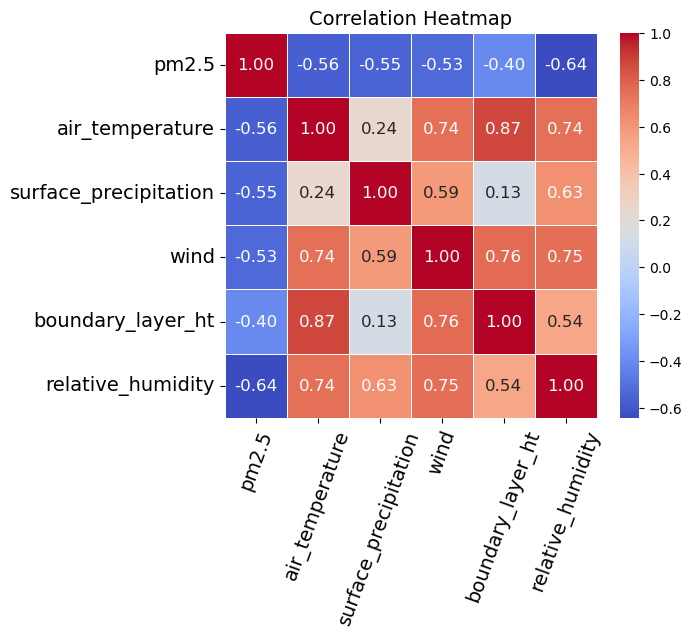

In [ ]:
corr_matrix = pm.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 12},
            xticklabels=True, yticklabels=True) # Display x-ticks and y-ticks

plt.tick_params(axis='both', which='major', labelsize=14) # Increase font size for x-ticks and y-ticks
plt.xticks(rotation=70)
plt.title("Correlation Heatmap", fontsize=14) # Increase font size for the title
plt.show()


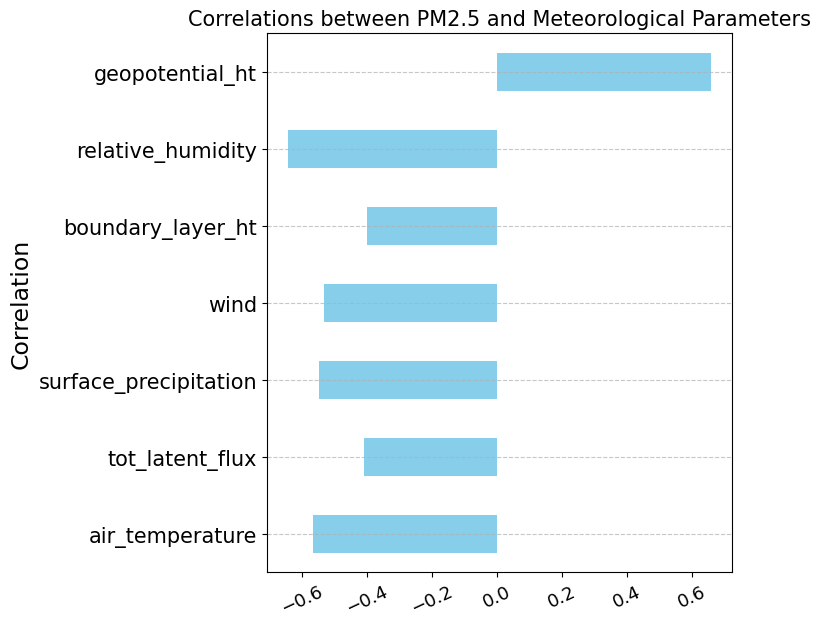

In [ ]:
correlations = pm.corr()['pm2.5'].drop('pm2.5')
plt.figure(figsize=(6, 7))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlations between PM2.5 and Meteorological Parameters', fontsize = 15)
plt.ylabel('Correlation', fontsize = 17)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=25, fontsize=13)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
scale = StandardScaler()

In [ ]:
X = pm[pm.index < '2015-12-01']

In [ ]:
xtrain, xtest, ytrain, ytest = TTS(X.drop(['pm2.5'], axis = 1), X['pm2.5'], shuffle = False, test_size = 0.1)
Xtrain = pd.DataFrame(scale.fit_transform(xtrain))
Xtest = pd.DataFrame(scale.transform(xtest))

In [ ]:
models = [
    #('SVM', SVR(kernel='linear')),
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=50, max_depth = 8)),
    ('Decision Tree', DecisionTreeRegressor()),
#     ('Deep Learning', Sequential([
#         Dense(64, input_dim=xtrain.shape[1], activation='relu'),
#         Dense(32, activation='relu'),
#         Dense(1)
#     ])),
#     ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror'))
]

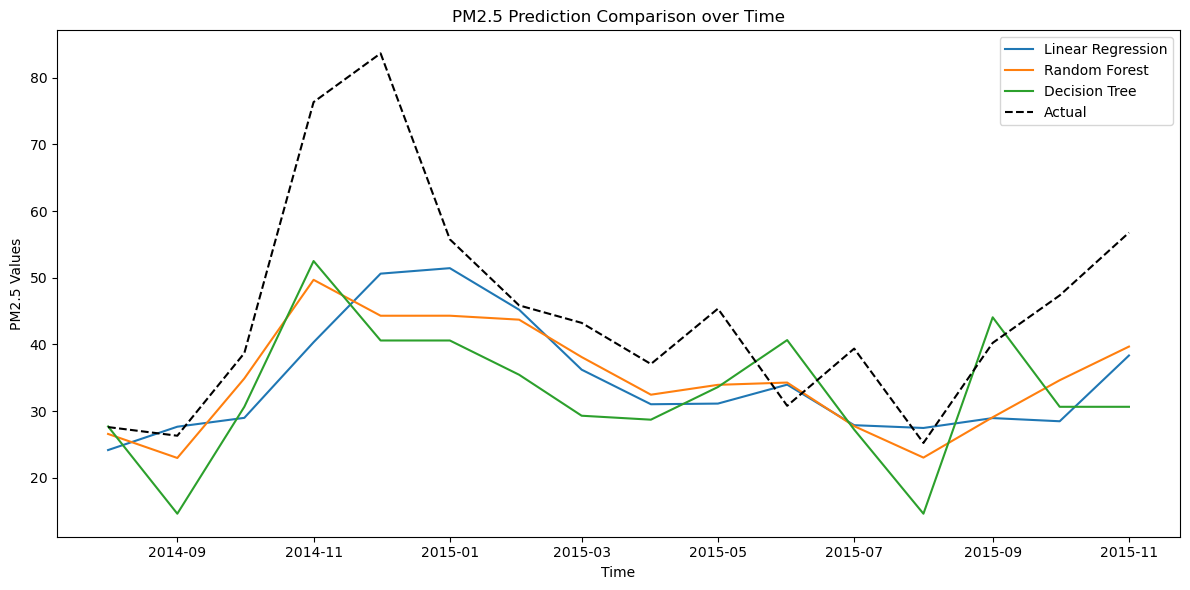

Linear Regression: Train RMSE=7.3724, Test RMSE=15.3560
Random Forest: Train RMSE=2.6855, Test RMSE=14.4242
Decision Tree: Train RMSE=0.0000, Test RMSE=17.1328


In [ ]:
time_series = xtest.index
train_mse = []
test_mse = []
model_predictions = {}

for name, model in models:
    if name == 'Deep Learning':
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)
    else:
        model.fit(xtrain, ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_error = MSE(ytrain, y_train_pred) ** (1/2)
    test_error = MSE(ytest, y_test_pred) ** (1/2)

    train_mse.append(train_error)
    test_mse.append(test_error)

    model_predictions[name] = y_test_pred

plt.figure(figsize=(12, 6))
for name, y_pred in model_predictions.items():
    plt.plot(time_series, y_pred, label=name)
plt.plot(time_series, ytest, label='Actual', linestyle='--', color='black')
plt.xlabel('Time')
plt.ylabel('PM2.5 Values')
plt.title('PM2.5 Prediction Comparison over Time')
plt.legend()
plt.tight_layout()
plt.show()

for name, train_err, test_err in zip([model[0] for model in models], train_mse, test_mse):
    print(f'{name}: Train RMSE={train_err:.4f}, Test RMSE={test_err:.4f}')

In [ ]:
model = RandomForestRegressor()

In [ ]:
plot_col = ['All', 'air_2m_temp', 'tot_latent_flux', 'tot_surf_precip', 'wind', 'blh',
       'rel_hum', 'geopotential_ht']

In [ ]:
xtrain.columns

Index(['air_temperature', 'tot_latent_flux', 'tot_surf_precip', 'wind',
       'boundary_layer_ht', 'relative_humidity', 'sp_hum_2m',
       'geopotential_ht'],
      dtype='object')

In [ ]:
mse, mae, rmse = [], [], []
model.fit(xtrain, ytrain)
pred = model.predict(xtest)
mse.append(MSE(ytest, pred))
mae.append(MAE(ytest, pred))
rmse.append((MSE(ytest, pred))**0.5)

for i in xtrain.columns :
    model.fit(xtrain.drop(i, axis = 1), ytrain)
    pred = model.predict(xtest.drop(i, axis = 1))
    mse.append(MSE(ytest, pred))
    mae.append(MAE(ytest, pred))
    rmse.append((MSE(ytest, pred))**0.5)

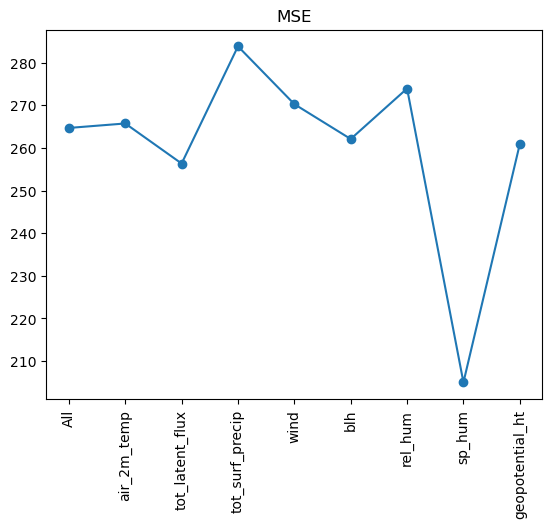

In [ ]:
plt.plot(plot_col, mse, marker = 'o')
plt.xticks(ticks = range(0, 8), rotation = 'vertical')
plt.title('MSE');

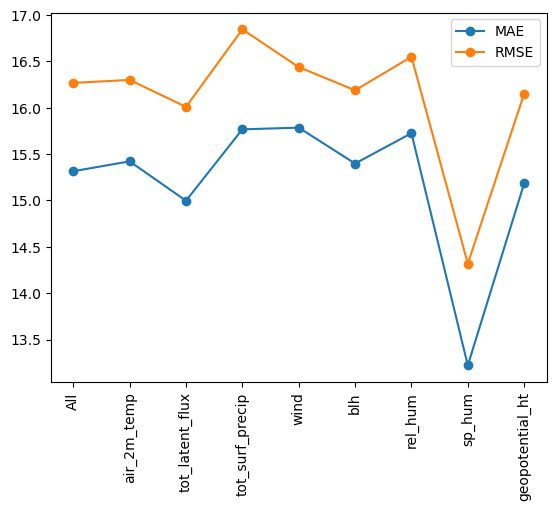

In [ ]:
plt.plot(plot_col, mae, marker = 'o', label = 'MAE')
plt.plot(plot_col, rmse, marker = 'o', label = 'RMSE')
plt.xticks(ticks = range(0, 8), rotation = 'vertical')
plt.legend();

In [ ]:
pm['month'] = pm.index.month

In [ ]:
model = RandomForestRegressor(random_state = 41)

In [ ]:
m = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

In [ ]:
xtrain.columns

NameError: name 'xtrain' is not defined

In [ ]:
pm

,pm2.5,air_temperature,tot_latent_flux,tot_surf_precip,wind,boundary_layer_ht,relative_humidity,sp_hum_2m,geopotential_ht,month
time,,,,,,,,,,
2003-01-01,48.582850,19.215576,35.730125,7.508941e-07,3.928336,420.594452,69.2500,0.008468,140.869919,1
2003-02-01,27.766492,24.944824,33.132473,2.746132e-06,3.659139,506.603729,73.0625,0.012500,118.834473,2
2003-03-01,38.404126,28.029358,40.111877,9.646870e-06,4.324845,612.599182,75.2500,0.014048,93.273529,3
2003-04-01,29.583028,33.363251,16.769913,5.410780e-06,5.157518,597.859802,78.6250,0.017113,60.156273,4
2003-05-01,36.456843,33.101227,58.450123,7.546639e-06,5.267358,694.715881,78.6250,0.018600,26.080709,5
...,...,...,...,...,...,...,...,...,...,...
2023-03-01,46.321432,28.131073,31.659157,5.270852e-06,3.955403,527.446960,75.5000,0.013106,104.607460,3
2023-04-01,47.857254,31.176544,77.169052,2.436518e-06,4.194080,481.318420,75.3750,0.015214,73.738861,4
2023-05-01,47.158392,32.325470,75.551201,6.715628e-06,4.798923,592.011108,78.0625,0.017968,55.523617,5


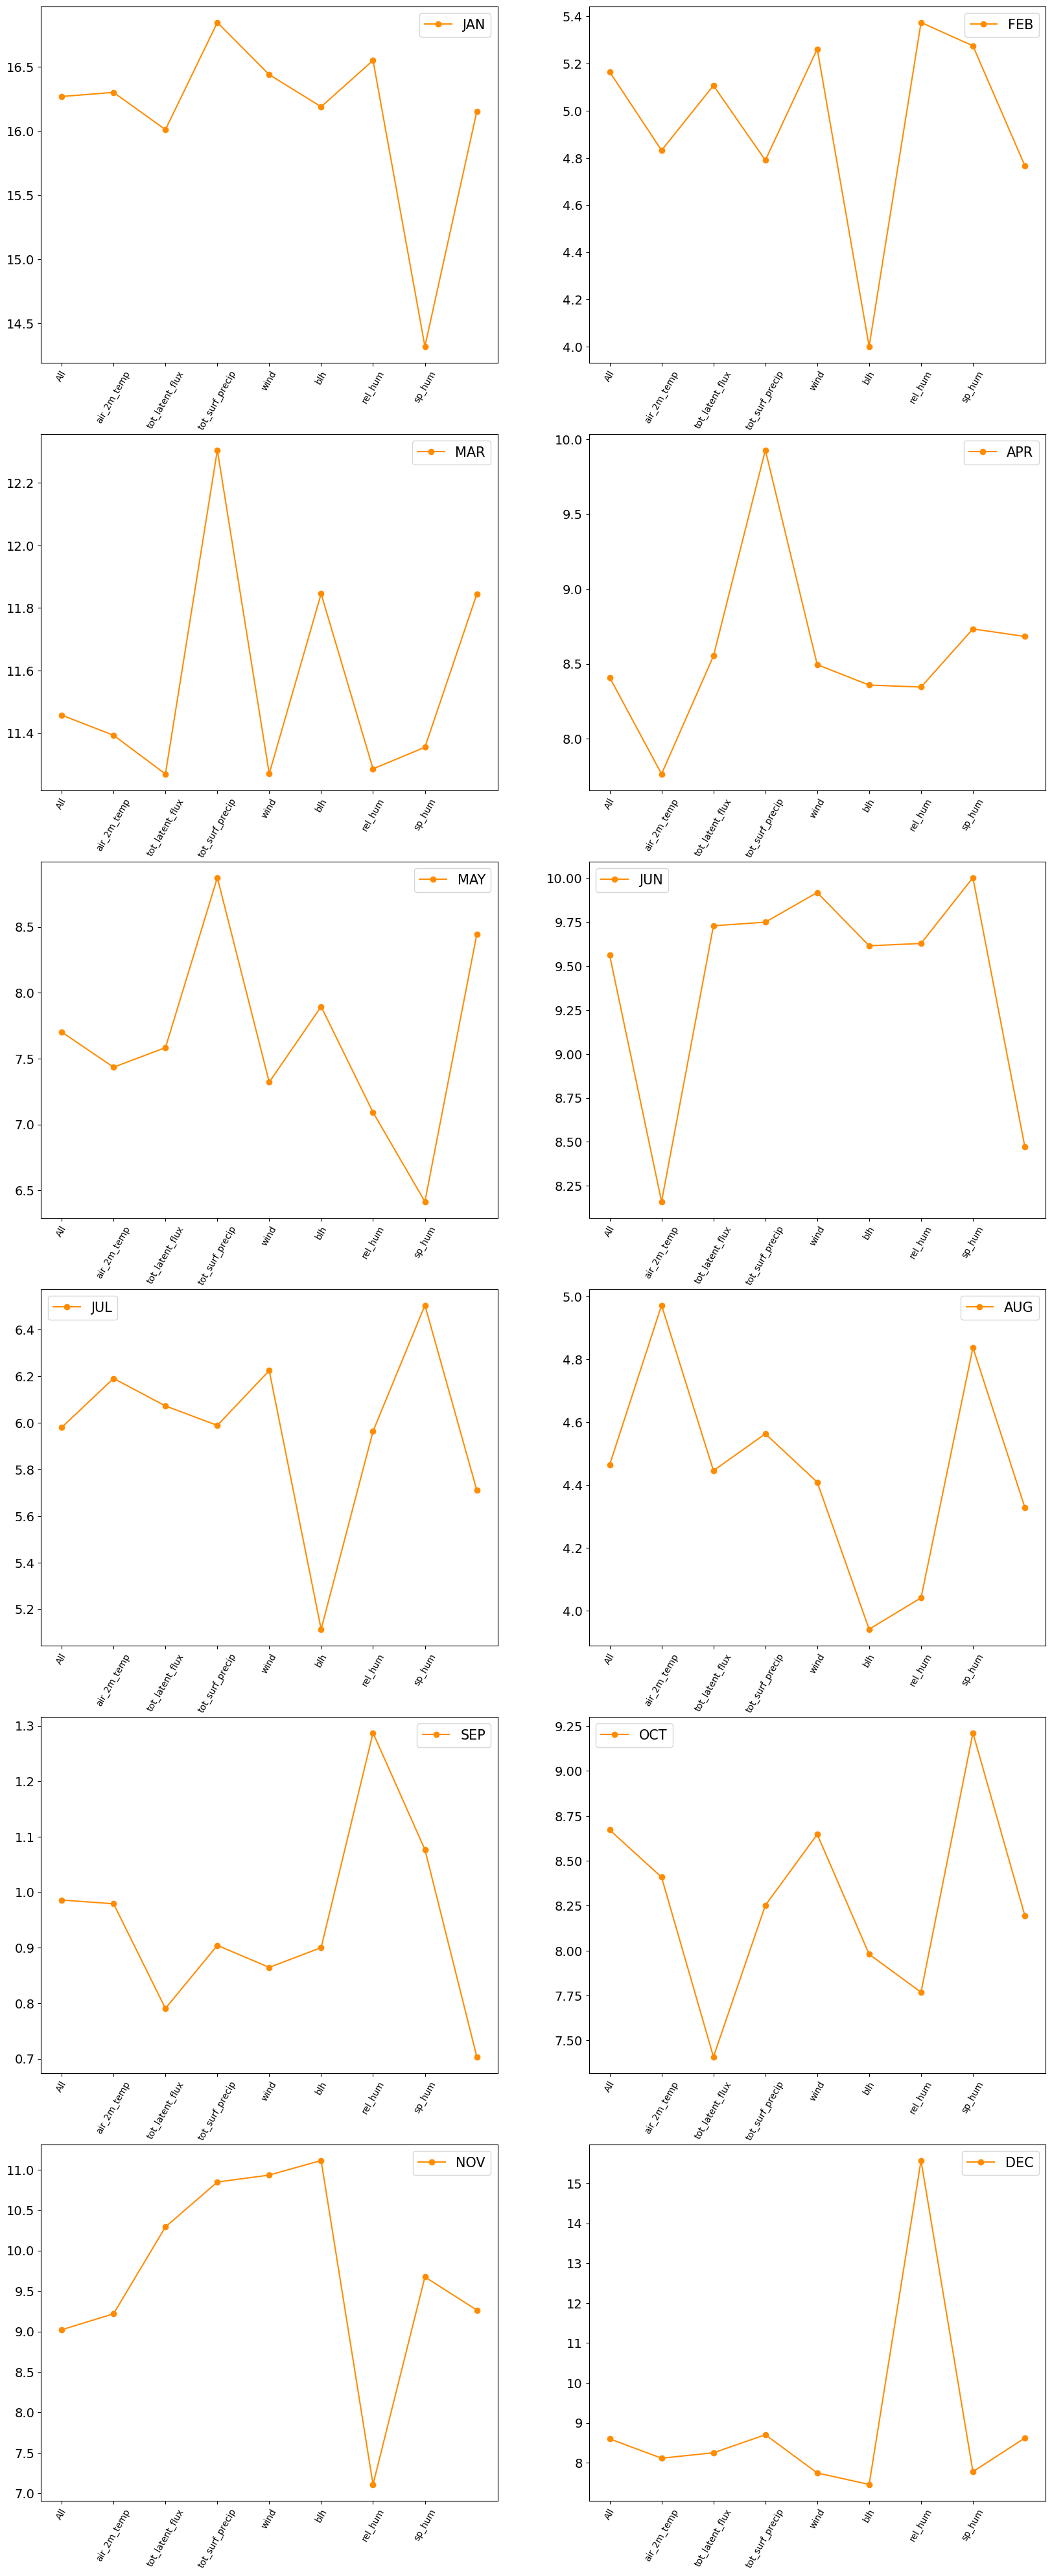

In [ ]:
plt.figure(figsize = (20,50))
rmse_year, rmse_least, param_least, param_year, rmse_all = [], [], [], [], []
w, p, t, b, r = [], [], [], [], []
for i in range(1, 13) :
    dummy = pm.loc[pm['month'] == i].drop('month', axis = 1)

    xtrain, xtest, ytrain, ytest = TTS(dummy.drop('pm2.5', axis = 1), dummy['pm2.5'], shuffle = False, test_size = 0.1, random_state = 41)
    Xtrain = pd.DataFrame(scale.fit_transform(xtrain))
    Xtest = pd.DataFrame(scale.transform(xtest))

    rmse = []
    model.fit(xtrain, ytrain)
    pred = model.predict(xtest)
    rmse.append((MSE(ytest, pred))**0.5)
    rmse_all.append((MSE(ytest, pred))**0.5)

    for j in xtrain.columns :
        model.fit(xtrain.drop(j, axis = 1), ytrain)
        pred = model.predict(xtest.drop(j, axis = 1))
        rmse.append((MSE(ytest, pred))**0.5)
        if j == 'air_2m_temp' :
            t.append((MSE(ytest, pred))**0.5)
        if j == 'tot_surf_precip' :
            p.append((MSE(ytest, pred))**0.5)
        if j == 'wind' :
            w.append((MSE(ytest, pred))**0.5)
        if j == 'blh' :
            b.append((MSE(ytest, pred))**0.5)
        if j == 'rel_hum' :
            r.append((MSE(ytest, pred))**0.5)

    #print(m[i-1])
    rmse_year.append(max(rmse))
    param_year.append(plot_col[rmse.index(max(rmse))])
    rmse_least.append(min(rmse))
    param_least.append(plot_col[rmse.index(min(rmse))])
    #print(rmse_year, param_year)

    plt.subplot(6, 2, i)
    plt.plot(plot_col, rmse, marker = 'o', label = m[i-1], color = 'darkorange')
    plt.xticks(ticks = range(0, 8), rotation = 60)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 15);

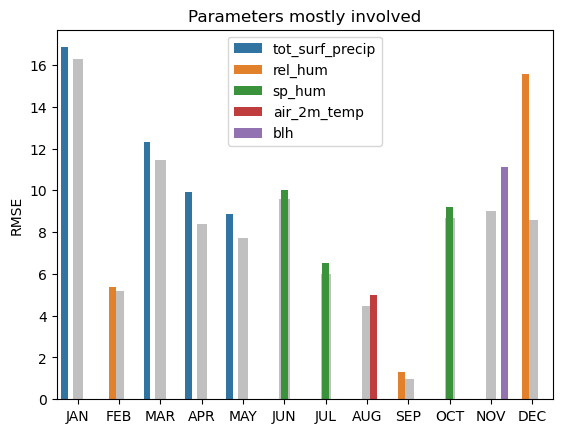

In [ ]:
sns.barplot(y = rmse_all, x = m, color = 'silver', width = 0.25)
sns.barplot(y = rmse_year, x = m, hue = param_year)
plt.ylabel('RMSE')
plt.title('Parameters mostly involved');

In [ ]:
Nikhil = np.array([t,r,w,p,b,rmse_all])

In [ ]:
import pandas as pd

# Assuming Nikhil is your numpy array
df = pd.DataFrame(Nikhil)
df.to_csv('nikhil.csv')

<BarContainer object of 12 artists>

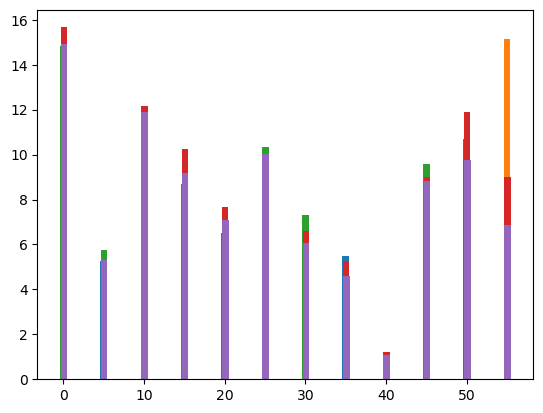

In [ ]:
bar_width = 0.02
x1 = np.arange(12) * 5  # Increase the range of x-values
x2 = [x + bar_width for x in x1]
x3 = [x + bar_width for x in x2]
x4 = [x + bar_width for x in x3]
x5 = [x + bar_width for x in x4]

plt.bar(x1, Nikhil[0, :])
plt.bar(x2, Nikhil[1, :])
plt.bar(x3, Nikhil[2, :])
plt.bar(x4, Nikhil[3, :])
plt.bar(x5, Nikhil[4, :])

<Axes: >

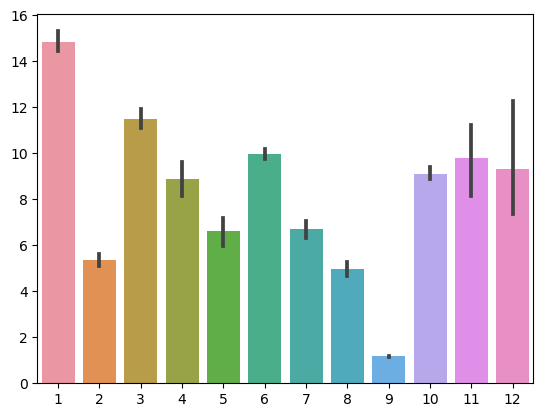

In [ ]:
import pandas as pd
import seaborn as sns

# Assuming Nikhil is a 2D numpy array
df = pd.DataFrame(Nikhil, columns=['1', '2', '3', '4', '5','6','7','8','9','10','11','12'])

sns.barplot(data=df)

<Axes: >

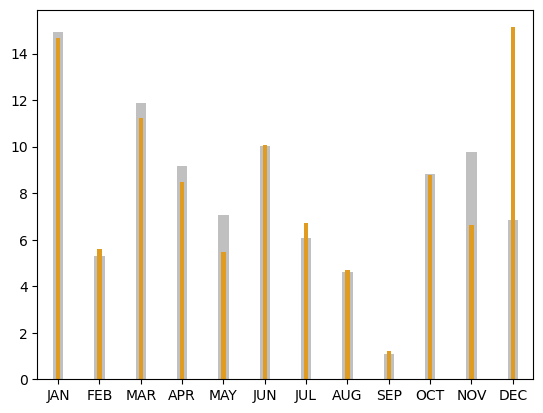

In [ ]:
sns.barplot(x = m, y = b, width = 0.25, color = 'silver')
sns.barplot(x = m, y = r, width = 0.1, color = 'orange')

In [ ]:
m

['JAN',
 'FEB',
 'MAR',
 'APR',
 'MAY',
 'JUN',
 'JUL',
 'AUG',
 'SEP',
 'OCT',
 'NOV',
 'DEC']

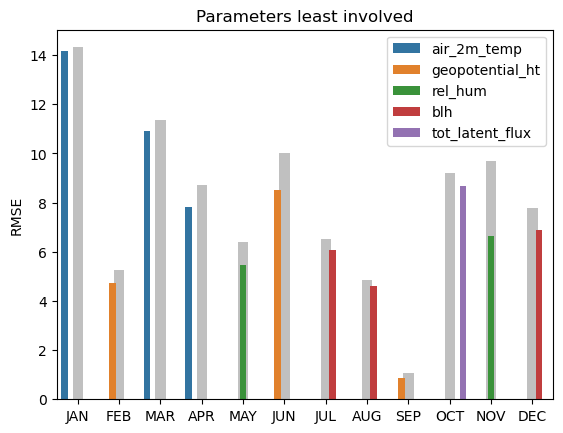

In [ ]:
sns.barplot(y = rmse_all, x = m, color = 'silver', width = 0.25)
sns.barplot(y = rmse_least, x = m, hue = param_least)
plt.ylabel('RMSE')
plt.title('Parameters least involved');

In [ ]:
pm[pm.index.month == 4][['pm2.5', 'tot_surf_precip']].corr()

,pm2.5,tot_surf_precip
pm2.5,1.000000,-0.488486
tot_surf_precip,-0.488486,1.000000


In [ ]:
pm[pm.index.month == 6].corr()

,pm2.5,air_2m_temp,tot_latent_flux,tot_surf_precip,wind,blh,rel_hum,geopotential_ht,month
pm2.5,1.000000,-0.019738,0.049172,-0.047580,-0.013641,-0.218171,0.037908,-0.203560,NaN
air_2m_temp,-0.019738,1.000000,-0.768467,-0.215515,0.294293,0.364037,-0.155745,-0.385034,NaN
tot_latent_flux,0.049172,-0.768467,1.000000,-0.137062,-0.440475,-0.478293,0.071516,0.366952,NaN
tot_surf_precip,-0.047580,-0.215515,-0.137062,1.000000,0.236830,0.056437,-0.364407,-0.215704,NaN
wind,-0.013641,0.294293,-0.440475,0.236830,1.000000,0.770629,-0.274551,-0.475173,NaN
blh,-0.218171,0.364037,-0.478293,0.056437,0.770629,1.000000,-0.030592,-0.285805,NaN
rel_hum,0.037908,-0.155745,0.071516,-0.364407,-0.274551,-0.030592,1.000000,0.284018,NaN
geopotential_ht,-0.203560,-0.385034,0.366952,-0.215704,-0.475173,-0.285805,0.284018,1.000000,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pm[pm.index.month == 3].corr()

,pm2.5,air_2m_temp,tot_latent_flux,tot_surf_precip,wind,blh,rel_hum,geopotential_ht,month
pm2.5,1.000000,0.287474,-0.351357,-0.628748,-0.040395,-0.214497,0.187518,-0.117009,NaN
air_2m_temp,0.287474,1.000000,-0.841350,-0.401821,0.463247,0.426991,0.196604,-0.516814,NaN
tot_latent_flux,-0.351357,-0.841350,1.000000,0.465128,-0.413926,-0.470490,-0.035991,0.442821,NaN
tot_surf_precip,-0.628748,-0.401821,0.465128,1.000000,0.012770,0.048675,-0.014454,0.179242,NaN
wind,-0.040395,0.463247,-0.413926,0.012770,1.000000,0.498933,0.341377,-0.348950,NaN
blh,-0.214497,0.426991,-0.470490,0.048675,0.498933,1.000000,-0.102056,-0.224905,NaN
rel_hum,0.187518,0.196604,-0.035991,-0.014454,0.341377,-0.102056,1.000000,0.331482,NaN
geopotential_ht,-0.117009,-0.516814,0.442821,0.179242,-0.348950,-0.224905,0.331482,1.000000,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
pm[pm.index.month == 12][['pm2.5', 'rel_hum']].corr()

,pm2.5,rel_hum
pm2.5,1.000000,0.513766
rel_hum,0.513766,1.000000


# MIDSEM Model

In [ ]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=50)),
    ('Decision Tree', DecisionTreeRegressor())
]

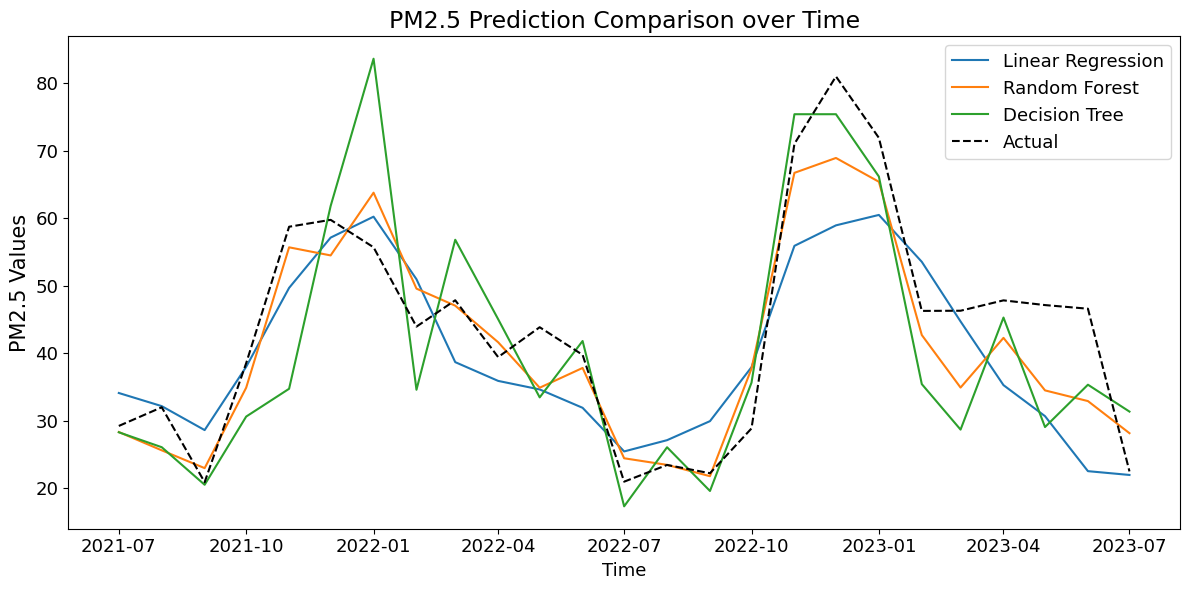

Linear Regression: Train RMSE=8.6807, Test RMSE=10.1354
Random Forest: Train RMSE=3.1300, Test RMSE=6.7280
Decision Tree: Train RMSE=0.0000, Test RMSE=10.7546


In [ ]:
time_series = xtest.index
train_mse = []
test_mse = []
model_predictions = {}

for name, model in models:
    if name == 'Deep Learning':
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)
    else:
        model.fit(xtrain, ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_error = MSE(ytrain, y_train_pred) ** (1/2)
    test_error = MSE(ytest, y_test_pred) ** (1/2)

    train_mse.append(train_error)
    test_mse.append(test_error)

    model_predictions[name] = y_test_pred

plt.figure(figsize=(12, 6))
for name, y_pred in model_predictions.items():
    plt.plot(time_series, y_pred, label=name)
plt.plot(time_series, ytest, label='Actual', linestyle='--', color='black')
plt.xlabel('Time', fontsize = 13)
plt.ylabel('PM2.5 Values', fontsize = 15)
plt.title('PM2.5 Prediction Comparison over Time', fontsize = 17)
plt.legend(fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

for name, train_err, test_err in zip([model[0] for model in models], train_mse, test_mse):
    print(f'{name}: Train RMSE={train_err:.4f}, Test RMSE={test_err:.4f}')

In [ ]:
coefficients = model.coef_
intercept = model.intercept_

# List of variable names (replace with your actual variable names)
variable_names = ['air_2m_temp', 'tot_latent_flux', 'tot_surf_precip', 'blh',
                  'u_wind', 'v_wind', 'rel_hum', 'sp_hum_2m', 'vert_press_velocity',
                  'geopotential_ht']

# Construct the equation
equation = f'PM2.5 = {intercept:.2f} '
for i in range(len(variable_names)):
    equation += f'+ ({coefficients[i]:.2f} * {variable_names[i]}) '

# Print the equation
print("Linear Regression Equation:")
print(equation)

AttributeError: 'DecisionTreeRegressor' object has no attribute 'coef_'

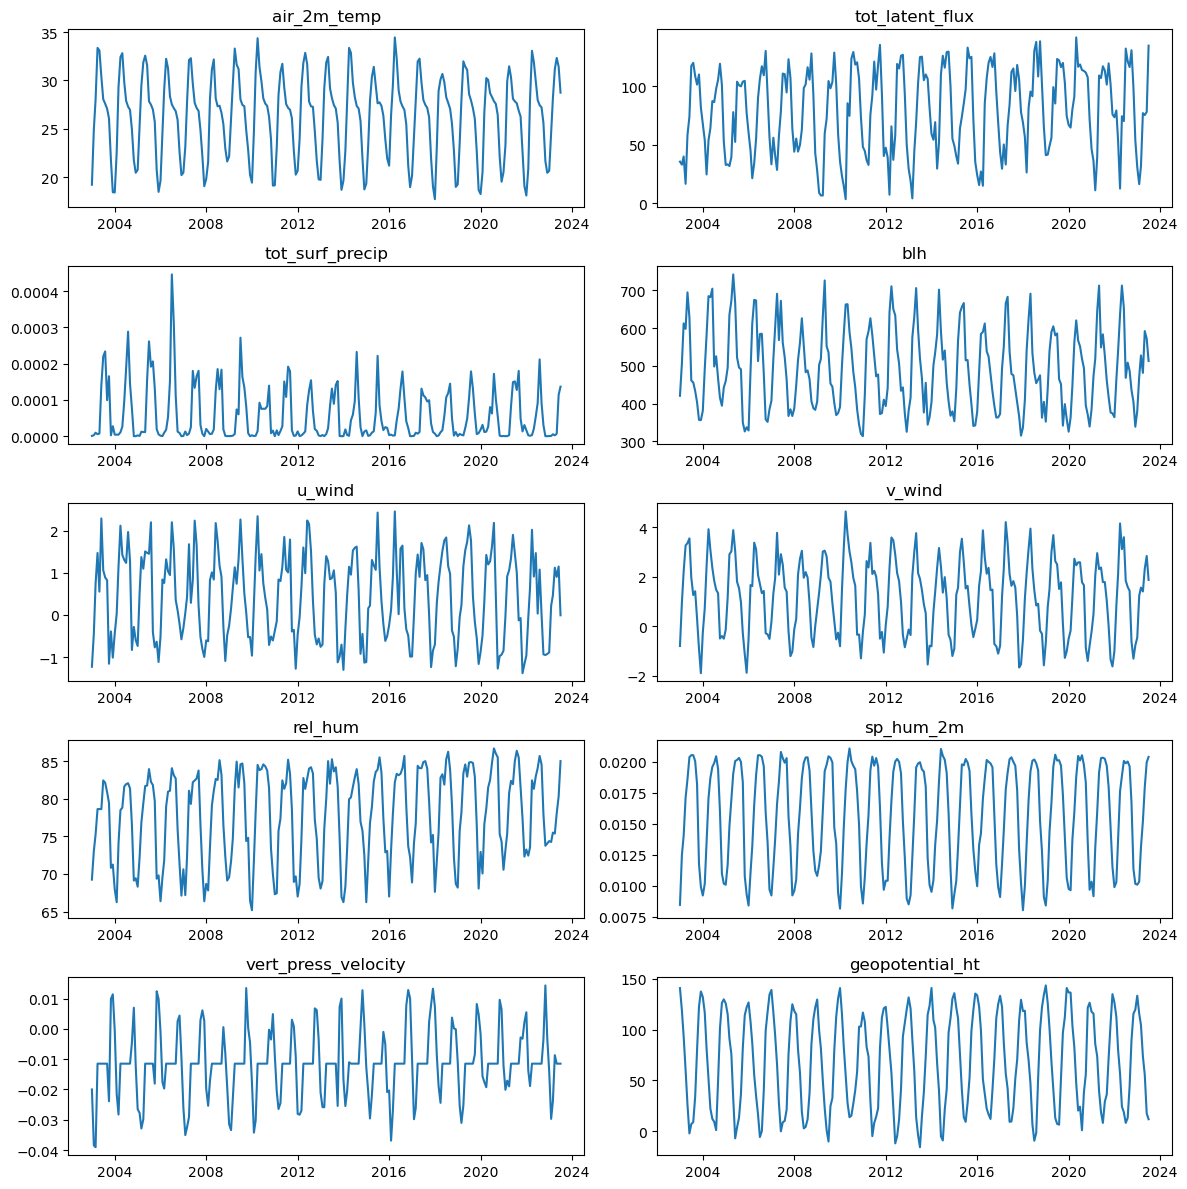

In [ ]:
j = 1
plt.figure(figsize = (12,12))
for i in pm.drop('pm2.5', axis = 1).columns :
    plt.subplot(5,2,j)
    j += 1
    plt.plot(pm[i])
    plt.title(i)
plt.tight_layout()

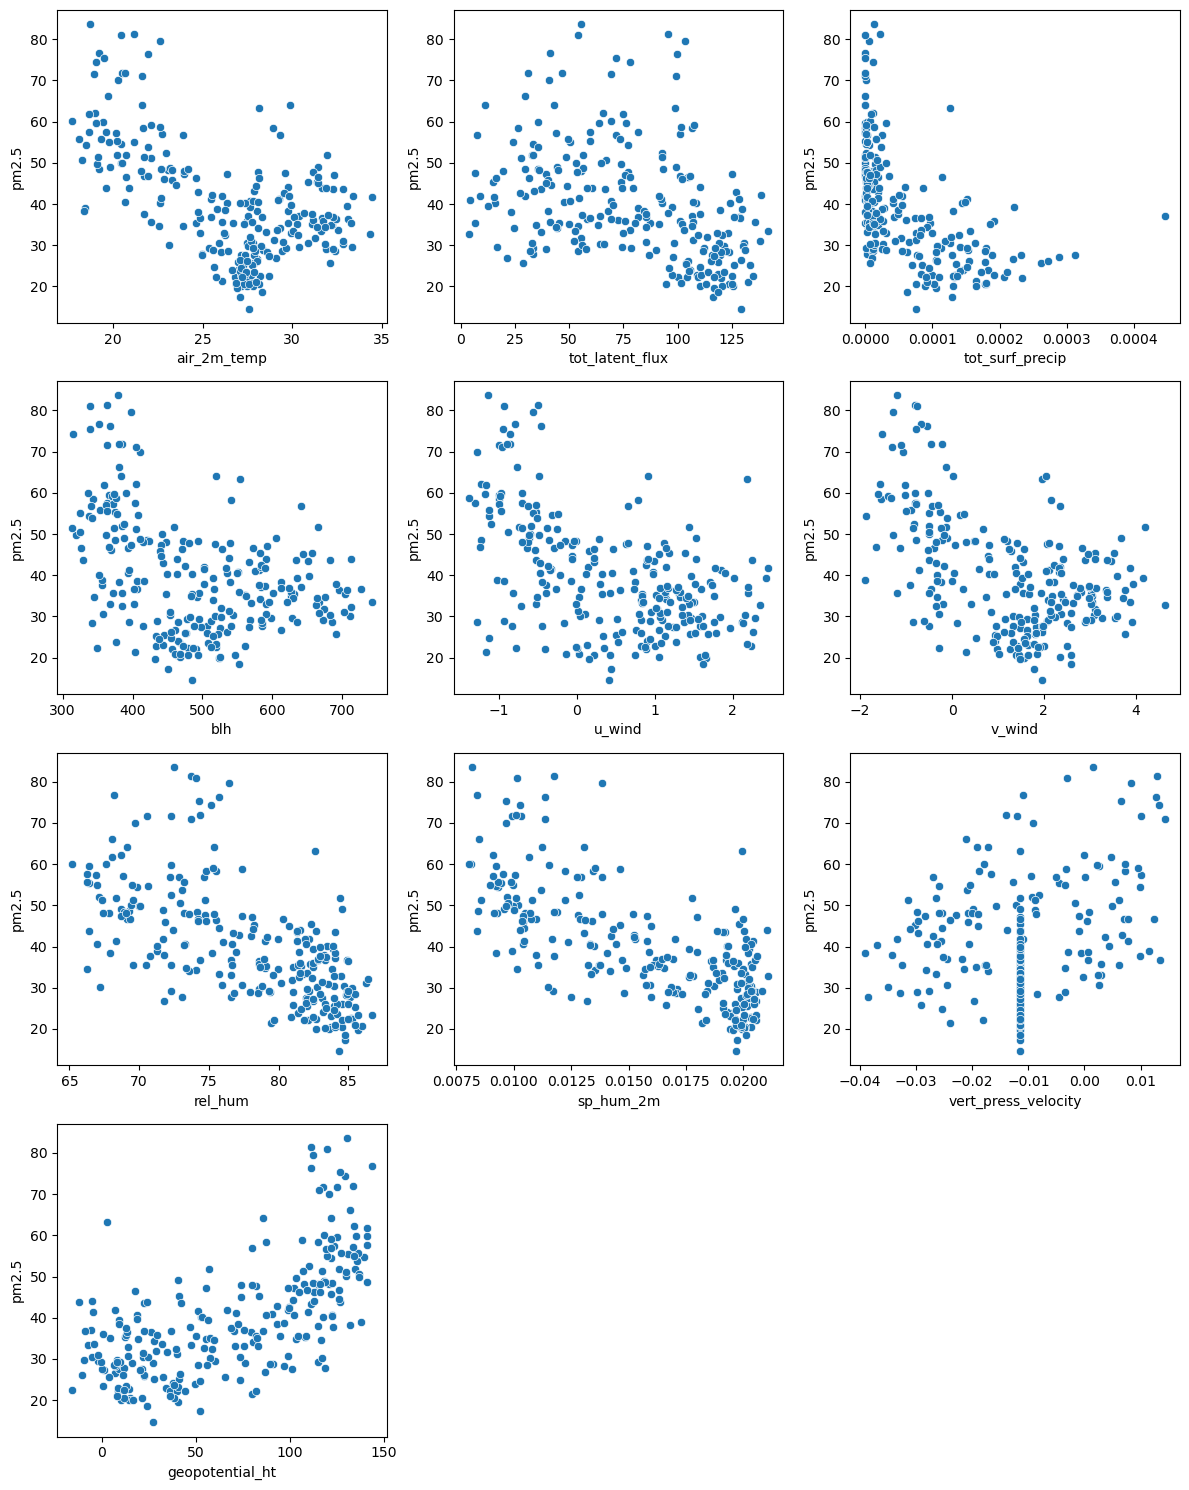

In [ ]:
j = 1
plt.figure(figsize = (12,15))
for i in pm.drop('pm2.5', axis = 1).columns :
    plt.subplot(4,3,j)
    j += 1
    sns.scatterplot(x = pm[i], y = pm['pm2.5'])
plt.tight_layout()

In [ ]:
pm['month'] = pm.index.month

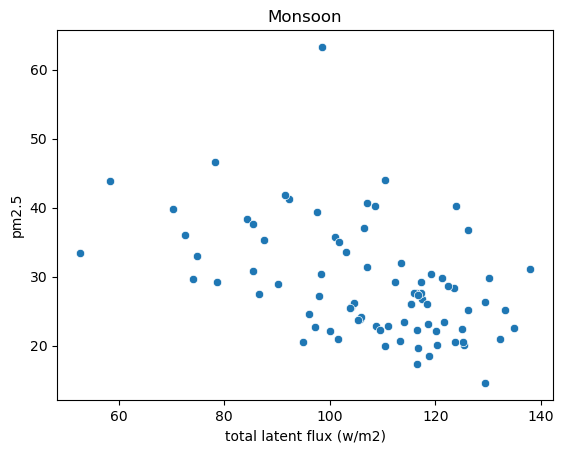

In [ ]:
sns.scatterplot(
    x=(pm['tot_latent_flux'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]),
    y=pm['pm2.5'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]
    )
plt.title('Monsoon')
plt.xlabel('total latent flux (w/m2)');

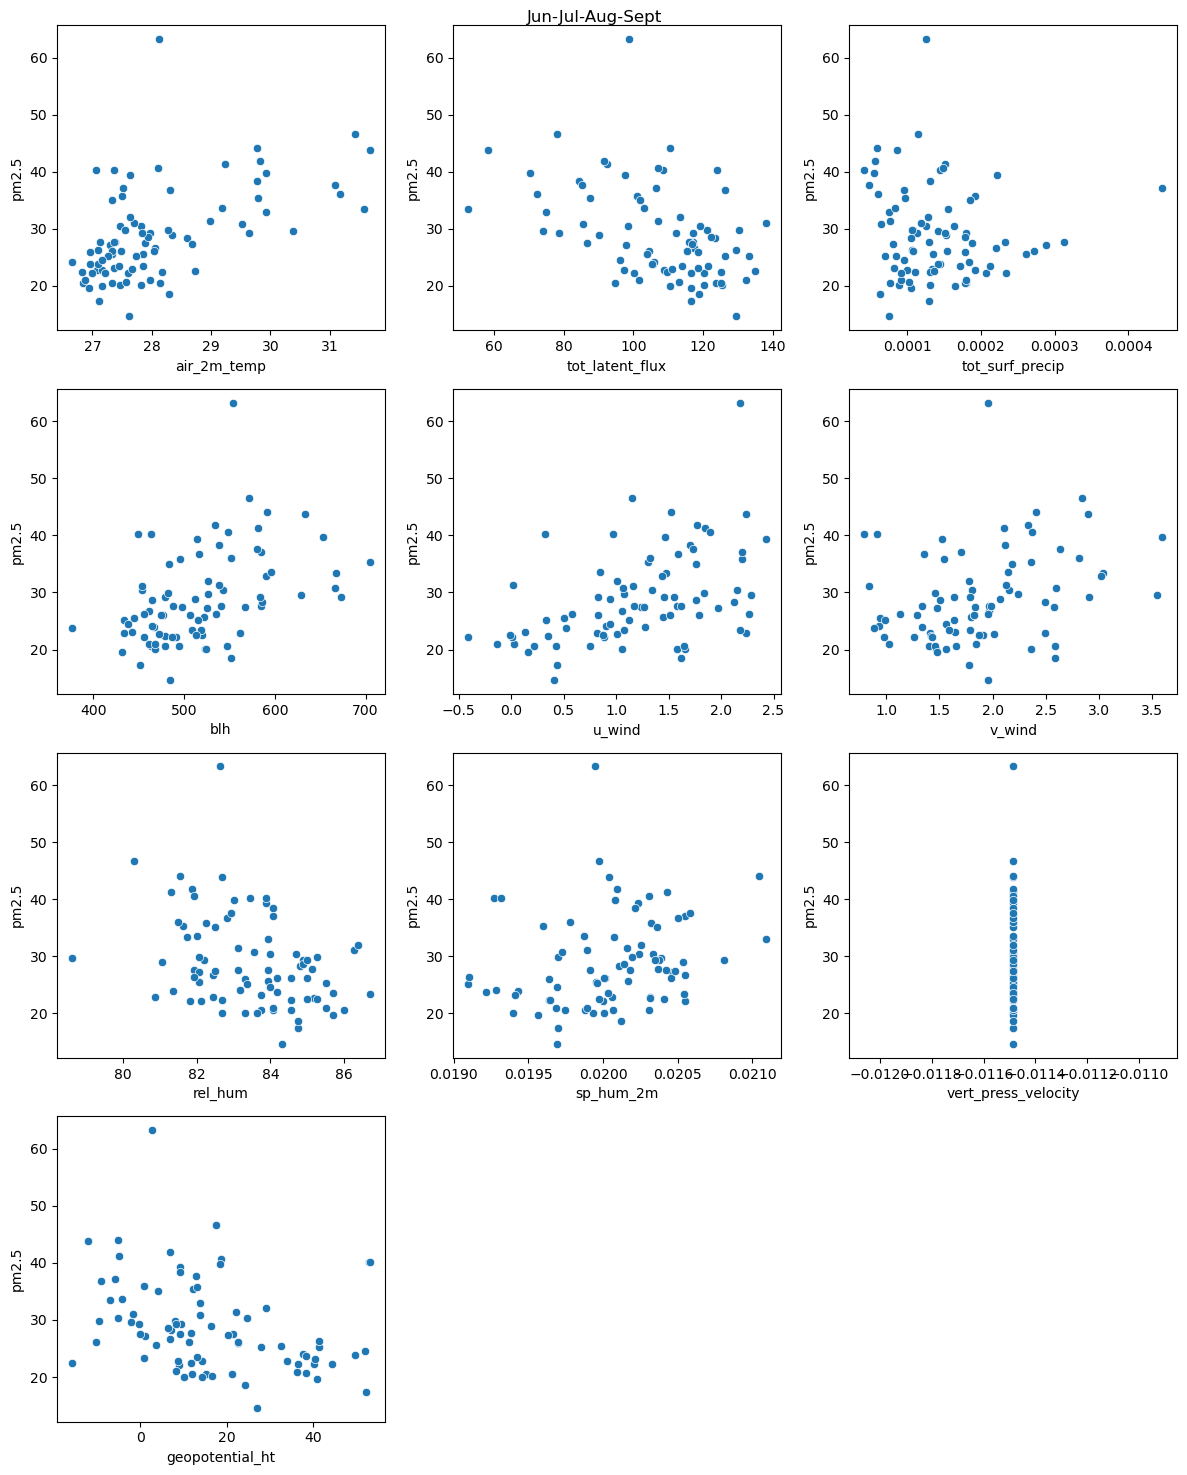

In [ ]:
j = 1
plt.figure(figsize = (12,15))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(4,3,j)
    j += 1
    sns.scatterplot(
    x=pm['air_2m_temp'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)],
    y=pm['pm2.5'][(pm['month'] == 6) | (pm['month'] == 7) | (pm['month'] == 8) | (pm['month'] == 9)]
    )
plt.title('')
plt.tight_layout();

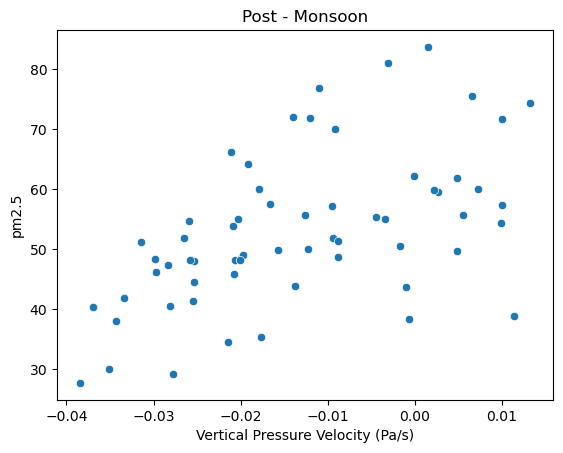

In [ ]:
sns.scatterplot(
    x=pm['vert_press_velocity'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)],
    y=pm['pm2.5'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)]
    )
plt.title('Post - Monsoon')
plt.xlabel('Vertical Pressure Velocity (Pa/s)');

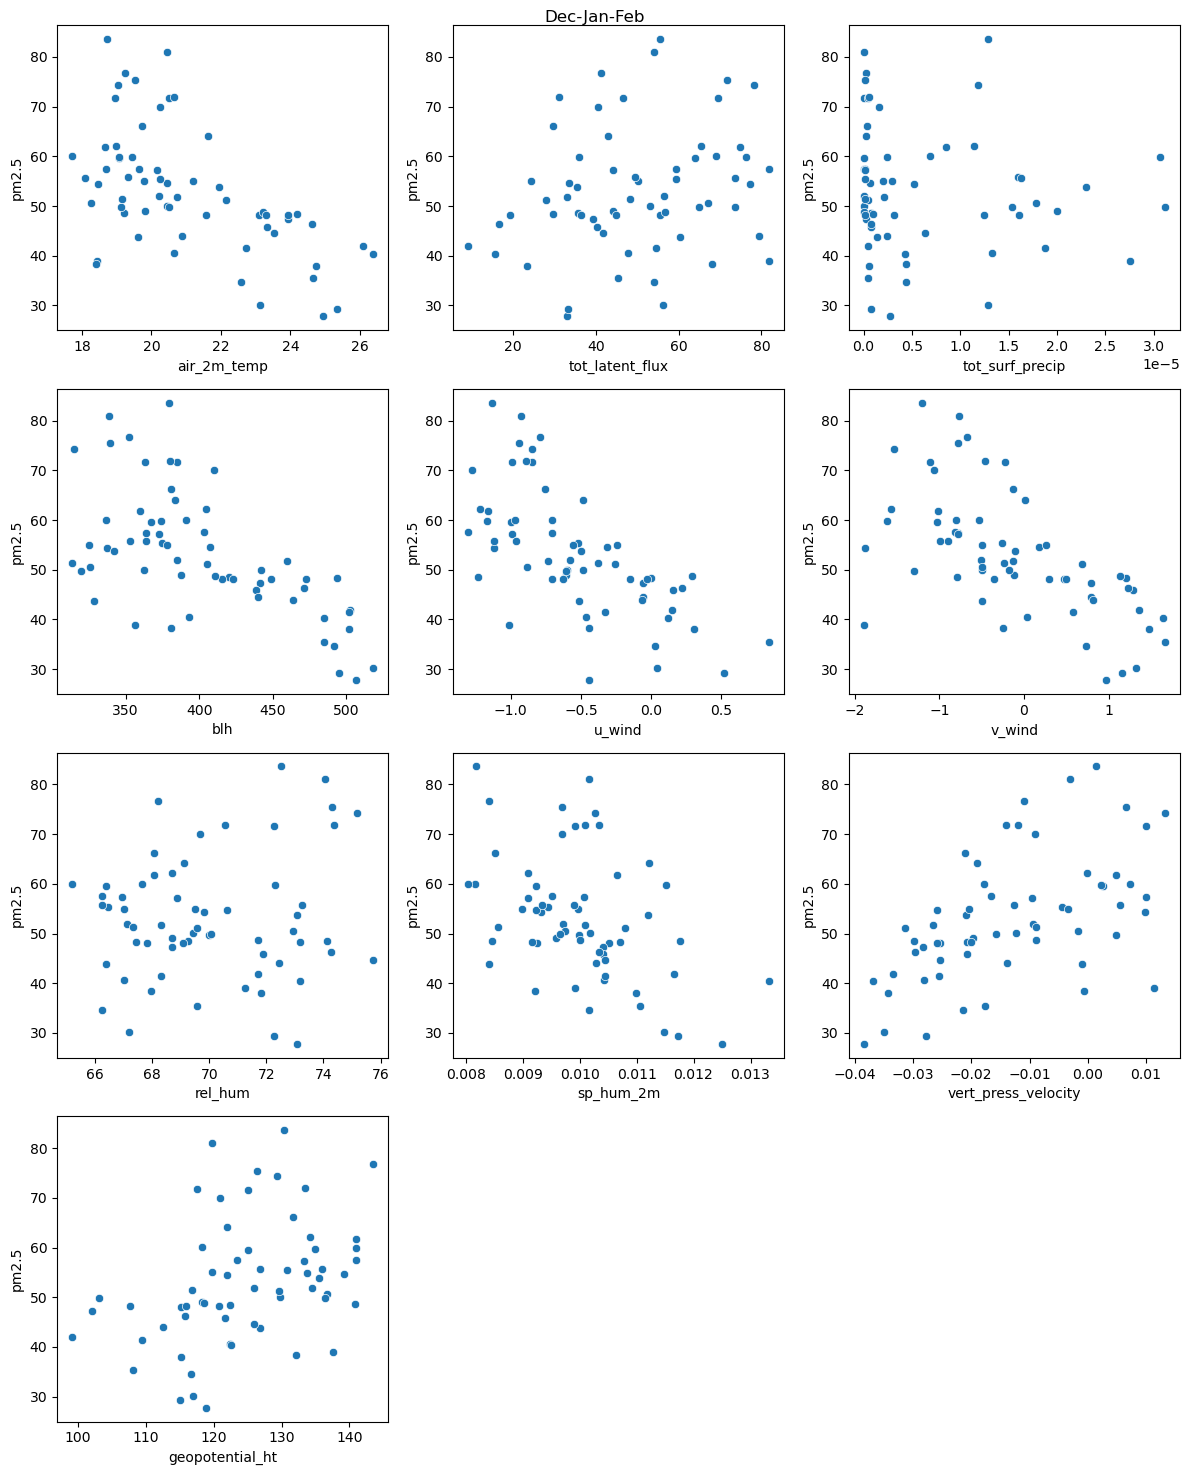

In [ ]:
j = 1
plt.figure(figsize = (12,15))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(4,3,j)
    j += 1
    sns.scatterplot(
    x=pm[i][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)],
    y=pm['pm2.5'][(pm['month'] == 1) | (pm['month'] == 2) | (pm['month'] == 12)]
    )
plt.suptitle('Dec-Jan-Feb')
plt.tight_layout();

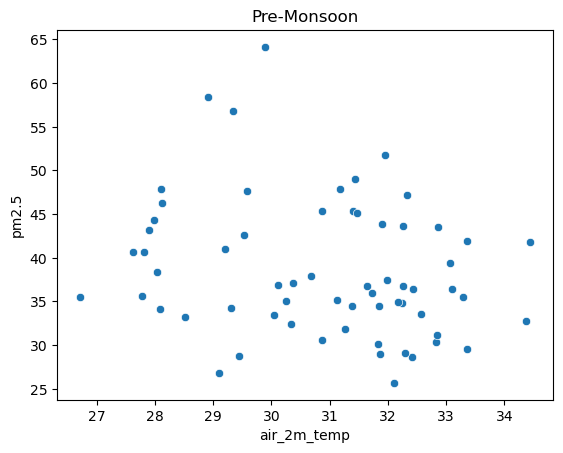

In [ ]:
sns.scatterplot(
    x=pm['air_2m_temp'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)],
    y=pm['pm2.5'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)]
    )
plt.title('Pre-Monsoon');

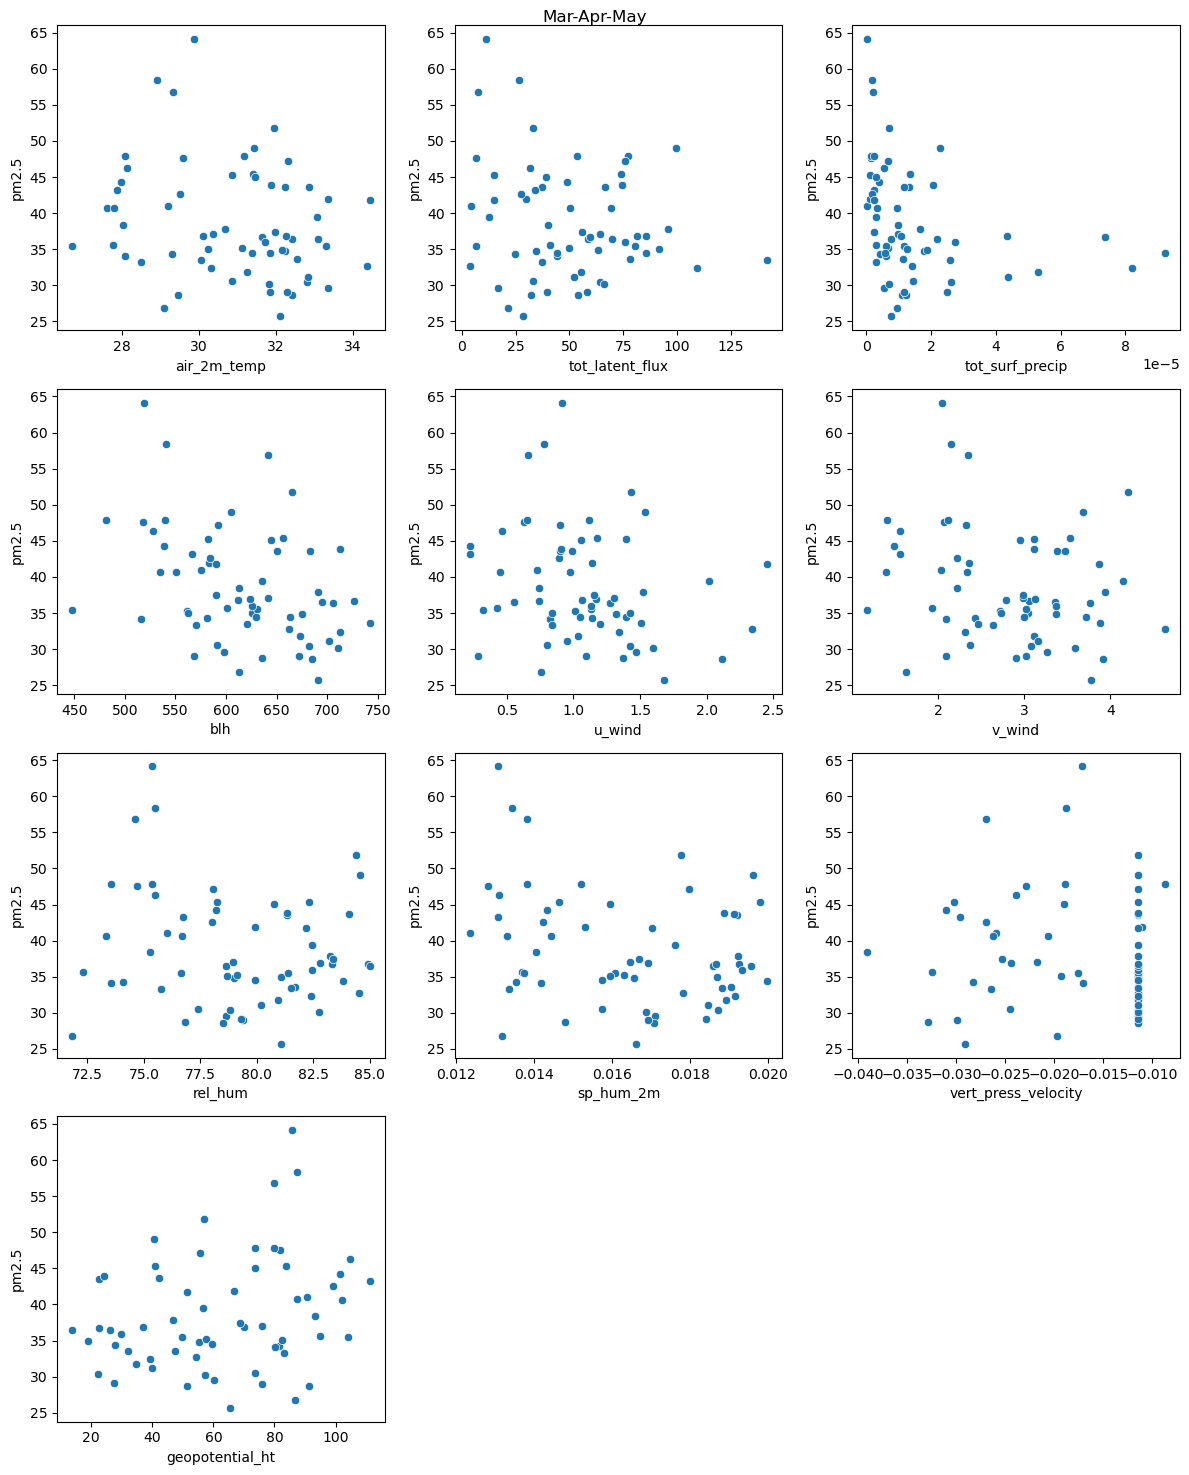

In [ ]:
j = 1
plt.figure(figsize = (12,15))
for i in pm.drop(['pm2.5', 'month'], axis = 1).columns :
    plt.subplot(4,3,j)
    j += 1
    sns.scatterplot(
    x=pm[i][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)],
    y=pm['pm2.5'][(pm['month'] == 3) | (pm['month'] == 4) | (pm['month'] == 5)]
    )
plt.suptitle('Mar-Apr-May')
plt.tight_layout();

In [ ]:
pm = pm.drop('month', axis = 1)

In [ ]:
pm.to_csv(r'C:\Users\AnnaSaiNikhil\Downloads\metereological\midsem_met_data.csv')

# Time Series Forecasting

## ML Models

In [ ]:
pm = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\Total Surface Mass Concentration - PM 2.5 monthly 0.5 x 0.625.nc')

In [ ]:
pm = pm.to_dataframe()

In [ ]:
pm.reset_index(drop = True, inplace = True)
pm = pm.drop('datamonth', axis = 1)
pm = pm[::2]
pm = pm.rename(columns = {'M2TMNXAER_5_12_4_TOTSMASS25' : 'pm2.5', 'time_bnds' : 'time'})
pm.set_index('time', inplace = True)
pm = pd.DataFrame(pm[:247])
pm['pm2.5'] = pm['pm2.5'] * 10 ** 9

In [ ]:
pm['month'] = pm.index.month
pm['mon_cat'] = 0
for i in range(len(pm)) :
    if pm['month'][i] in (7,8,9) :
        pm['mon_cat'][i] = 1
    elif pm['month'][i] in (2,3,4,5,6) :
        pm['mon_cat'][i] = 2
    else :
        pm['mon_cat'][i] = 3
pm.head()

,pm2.5,month,mon_cat
time,,,
2003-01-01,48.582850,1,3
2003-02-01,27.766492,2,2
2003-03-01,38.404126,3,2
2003-04-01,29.583028,4,2
2003-05-01,36.456843,5,2


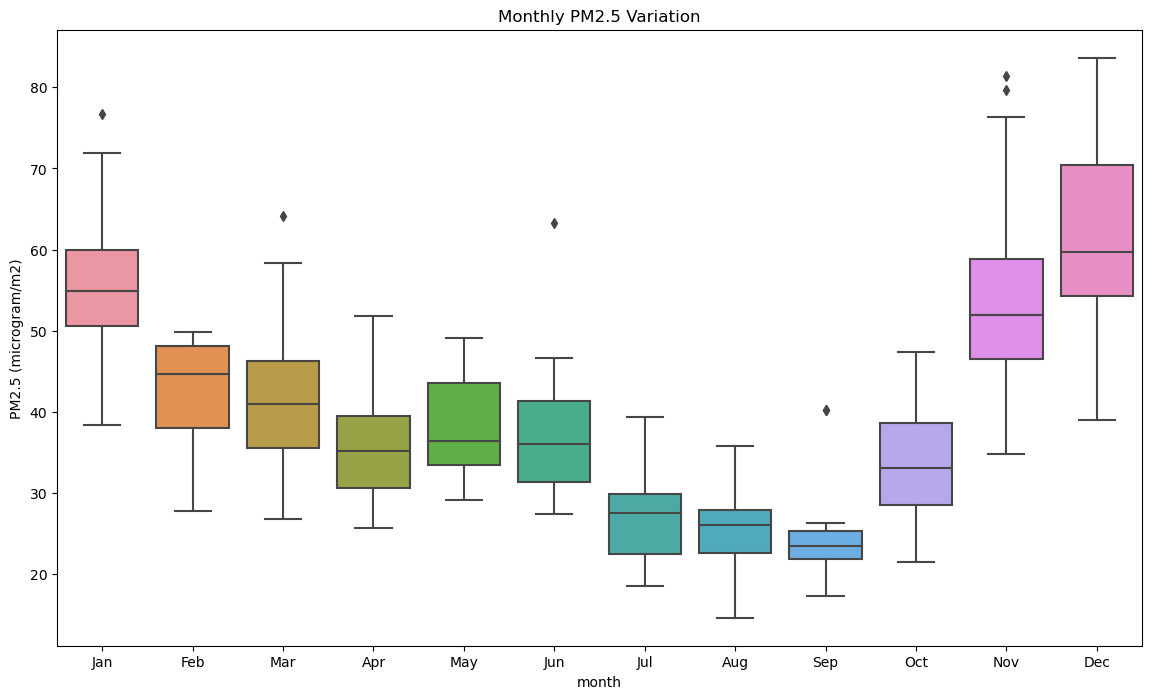

In [ ]:
plt.figure(figsize = (14, 8))
sns.boxplot(x = pm['month'], y = pm['pm2.5'])
plt.ylabel('PM2.5 (microgram/m2)')
plt.xticks(ticks = (0,1,2,3,4,5,6,7,8,9,10,11), labels = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.title('Monthly PM2.5 Variation');

In [ ]:
pm = pm.drop('month', axis = 1)

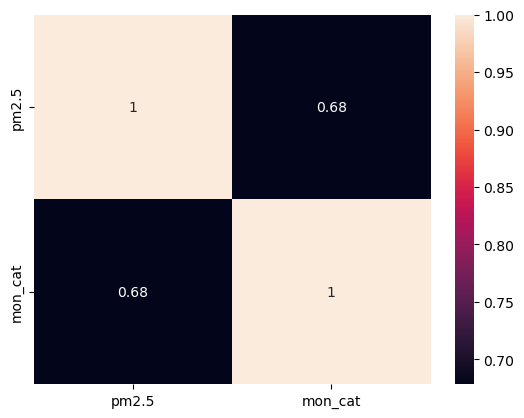

In [ ]:
sns.heatmap(pm.corr(), annot = True);

In [ ]:
pm['lag1'] = np.nan
pm['lag1'][1:] = pm['pm2.5'][:-1]
pm['lag1'][:1] = pm['pm2.5'][:1]
pm['lag12'] = np.nan
pm['lag12'][12:] = pm['pm2.5'][:-12]
pm['lag12'][:12] = pm['pm2.5'][:12]
pm['lag24'] = np.nan
pm['lag24'][24:] = pm['pm2.5'][:-24]
pm['lag24'][:24] = pm['pm2.5'][:24]
pm['lag36'] = np.nan
pm['lag36'][36:] = pm['pm2.5'][:-36]
pm['lag36'][:36] = pm['pm2.5'][:36]

In [ ]:
pm.tail()

,pm2.5,mon_cat,lag1,lag12,lag24,lag36
time,,,,,,
2023-03-01,46.321432,2,46.295807,47.871423,64.144111,35.484456
2023-04-01,47.857254,2,46.321432,39.454989,45.067299,35.049311
2023-05-01,47.158392,2,47.857254,43.878294,32.371525,33.488244
2023-06-01,46.619498,2,47.158392,39.788617,40.612191,27.386083
2023-07-01,22.527423,1,46.619498,21.004056,29.258742,18.576276


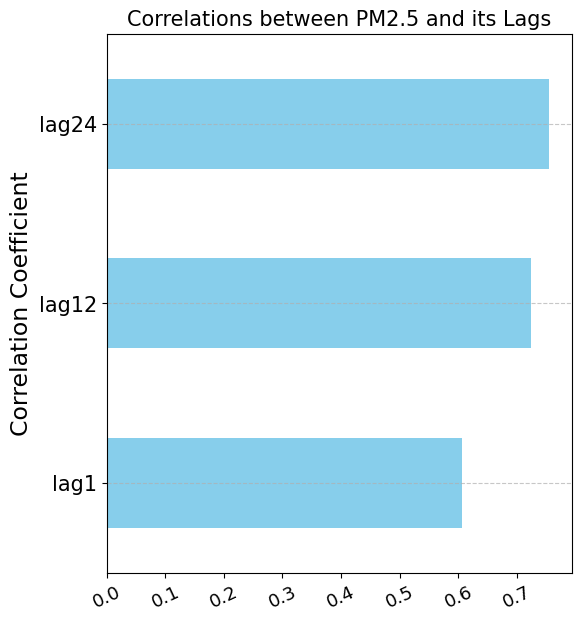

In [ ]:
correlations = pm.corr()['pm2.5'].drop(['pm2.5', 'lag36', 'mon_cat'])
plt.figure(figsize=(6, 7))
correlations.plot(kind='barh', color='skyblue')
plt.title('Correlations between PM2.5 and its Lags', fontsize = 15)
plt.ylabel('Correlation Coefficient', fontsize = 17)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=25, fontsize=13)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
pm.corr()

,pm2.5,mon_cat,lag1,lag12,lag24,lag36
pm2.5,1.000000,0.678195,0.606328,0.724653,0.755194,0.821084
mon_cat,0.678195,1.000000,0.334327,0.666048,0.653969,0.651974
lag1,0.606328,0.334327,1.000000,0.542570,0.602382,0.541561
lag12,0.724653,0.666048,0.542570,1.000000,0.717060,0.734656
lag24,0.755194,0.653969,0.602382,0.717060,1.000000,0.717478
lag36,0.821084,0.651974,0.541561,0.734656,0.717478,1.000000


In [ ]:
vif = pd.DataFrame()
vif['variables'] = pm.drop('pm2.5', axis = 1).columns
vif['values'] = [VIF(pm.drop('pm2.5', axis = 1).values, i) for i in range(pm.drop('pm2.5', axis = 1).shape[1])]
vif

,variables,values
0,mon_cat,18.217498
1,lag1,14.046238
2,lag12,26.739690
3,lag24,27.656685
4,lag36,26.801507


In [ ]:
xtrain, xtest, ytrain, ytest = TTS(pm[['mon_cat','lag1', 'lag12', 'lag24']], pm['pm2.5'], shuffle = False, test_size = 0.1)
#xtrain = np.array(xtrain).reshape(-1,1)
#ytrain = np.array(ytrain).reshape(-1,1)
#xtest = np.array(xtest).reshape(-1,1)

In [ ]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=50)),
    ('Decision Tree', DecisionTreeRegressor())
]

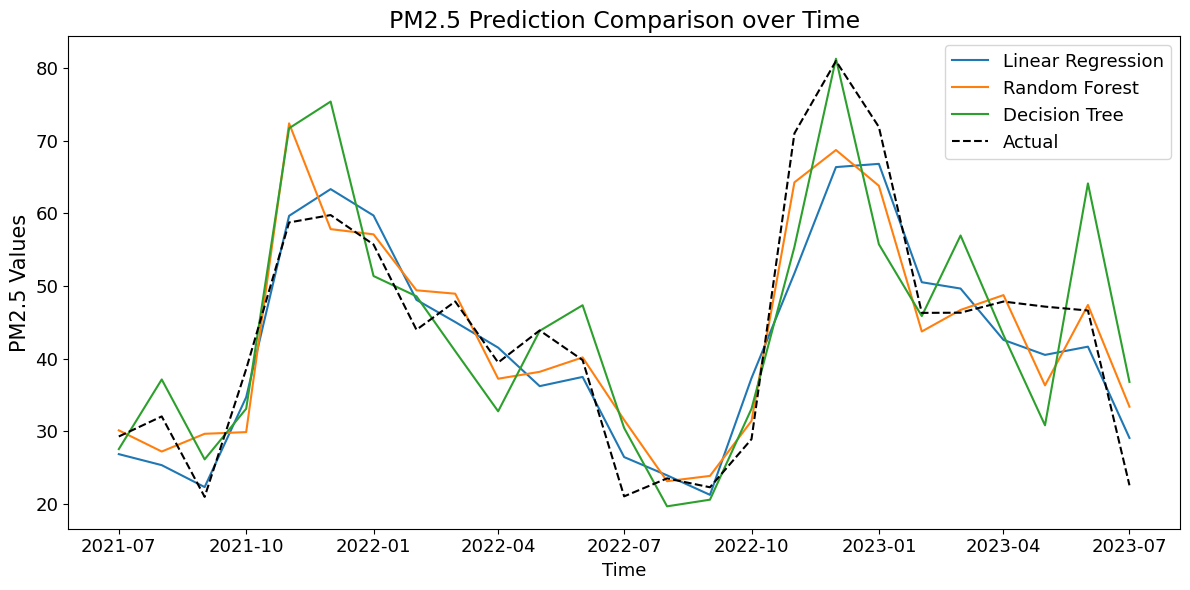

Linear Regression: Train RMSE=7.9071, Test RMSE=6.5516
Random Forest: Train RMSE=3.0245, Test RMSE=6.5155
Decision Tree: Train RMSE=0.0000, Test RMSE=9.4488


In [ ]:
time_series = xtest.index
train_mse = []
test_mse = []
model_predictions = {}

for name, model in models:
    if name == 'Deep Learning':
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)
    else:
        model.fit(xtrain, ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_error = MSE(ytrain, y_train_pred) ** (1/2)
    test_error = MSE(ytest, y_test_pred) ** (1/2)

    train_mse.append(train_error)
    test_mse.append(test_error)

    model_predictions[name] = y_test_pred

plt.figure(figsize=(12, 6))
for name, y_pred in model_predictions.items():
    plt.plot(time_series, y_pred, label=name)
plt.plot(time_series, ytest, label='Actual', linestyle='--', color='black')  # Actual data
plt.xlabel('Time', fontsize = 13)
plt.ylabel('PM2.5 Values', fontsize = 15)
plt.title('PM2.5 Prediction Comparison over Time', fontsize = 17)
plt.legend(fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.tight_layout()
plt.show()

for name, train_err, test_err in zip([model[0] for model in models], train_mse, test_mse):
    print(f'{name}: Train RMSE={train_err:.4f}, Test RMSE={test_err:.4f}')

In [ ]:
models = [
    ('SVM', SVR(kernel='linear')),
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(n_estimators=50)),
    ('Decision Tree', DecisionTreeRegressor()),
    ('Deep Learning', Sequential([
        Dense(64, input_dim=xtrain.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])),
    ('XGBoost', xgb.XGBRegressor(objective='reg:squarederror'))
]

1/1 [==============================] - 0s 31ms/step


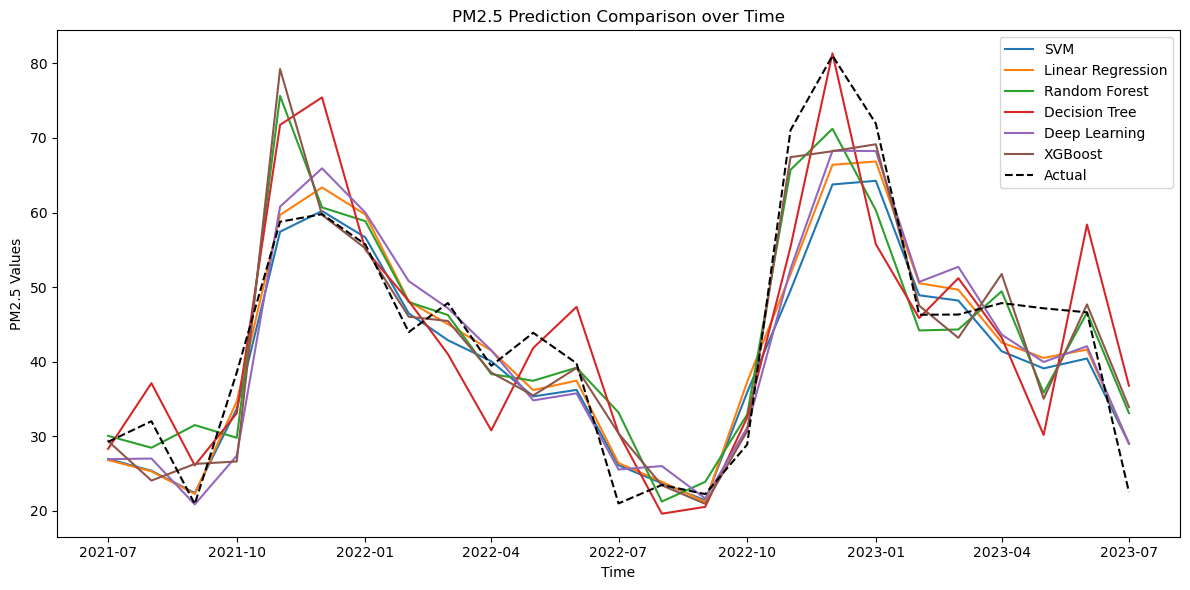

SVM: Train RMSE=8.0339, Test RMSE=7.1759
Linear Regression: Train RMSE=7.9071, Test RMSE=6.5516
Random Forest: Train RMSE=3.0918, Test RMSE=7.0462
Decision Tree: Train RMSE=0.0000, Test RMSE=8.9427
Deep Learning: Train RMSE=8.2643, Test RMSE=6.6694
XGBoost: Train RMSE=0.0370, Test RMSE=7.2603


In [ ]:
time_series = plots.index
train_mse = []
test_mse = []
model_predictions = {}

for name, model in models:
    if name == 'Deep Learning':
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(xtrain, ytrain, epochs=50, batch_size=32, verbose=0)
    else:
        model.fit(xtrain, ytrain)

    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)

    train_error = MSE(ytrain, y_train_pred) ** (1/2)
    test_error = MSE(ytest, y_test_pred) ** (1/2)

    train_mse.append(train_error)
    test_mse.append(test_error)

    model_predictions[name] = y_test_pred

plt.figure(figsize=(12, 6))
for name, y_pred in model_predictions.items():
    plt.plot(time_series, y_pred, label=name)
plt.plot(time_series, ytest, label='Actual', linestyle='--', color='black')  # Actual data
plt.xlabel('Time')
plt.ylabel('PM2.5 Values')
plt.title('PM2.5 Prediction Comparison over Time')
plt.legend()
plt.tight_layout()
plt.show()

for name, train_err, test_err in zip([model[0] for model in models], train_mse, test_mse):
    print(f'{name}: Train RMSE={train_err:.4f}, Test RMSE={test_err:.4f}')

## SARIMA Model

## AIC

In [ ]:
p_values = [0, 1, 2, 3]  # Autoregressive (AR) order
d_values = [0, 1]       # Integrated (I) order
q_values = [0, 1, 2, 3]  # Moving Average (MA) order
P_values = [0, 1, 2, 3]  # Seasonal AR order
D_values = [0, 1]       # Seasonal I order
Q_values = [0, 1, 2, 3]  # Seasonal MA order
s = 12  # Seasonal periodicity (e.g., for monthly data, s=12 for yearly s=1)

# Create lists to store AIC values and model configurations
aic_values = []
sarima_configs = []

# Iterate over all possible SARIMA configurations
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Create the SARIMA model
        sarima_model = sm.tsa.SARIMAX(pm['pm2.5'], order=(p, d, q), seasonal_order=(P, D, Q, s))

        # Fit the model to your data
        sarima_results = sarima_model.fit()

        # Calculate AIC and append to the list
        aic = sarima_results.aic
        aic_values.append(aic)

        # Store the SARIMA configuration for later reference
        sarima_configs.append(((p, d, q), (P, D, Q, s)))

        print(f'SARIMA{(p, d, q)}{(P, D, Q, s)} AIC: {aic}')
    except:
        continue

# Find the SARIMA configuration with the lowest AIC
best_index = np.argmin(aic_values)
best_aic = aic_values[best_index]
best_sarima = sarima_configs[best_index]

print(f'Best SARIMA model: SARIMA{best_sarima} with AIC: {best_aic}')


AIC - 3,0,0,3,0,2,12

## MSE

In [ ]:
time_series = pm.index  # Replace 'Date' with your date column
pm25_values = pm['pm2.5']  # Replace 'PM2.5' with your PM2.5 column

# Convert time series data to datetime index
time_series = pd.to_datetime(time_series)
p = pd.Series(pm25_values, index=time_series)

# Split data into training and testing sets
train_data = p[:-24]  # Use all data except the last 12 months for training
test_data = p[-24:]  # Use the last 12 months for testing

# Define SARIMA hyperparameters to search over
p_values = [0, 1, 2, 3]  # Autoregressive (AR) order
d_values = [0, 1]       # Integrated (I) order
q_values = [0, 1, 2, 3]  # Moving Average (MA) order
P_values = [0, 1, 2, 3]  # Seasonal AR order
D_values = [0, 1]       # Seasonal I order
Q_values = [0, 1, 2, 3]  # Seasonal MA order
s = 12  # Seasonal periodicity (e.g., for monthly data, s=12 for yearly s=1)

# Initialize variables to store best hyperparameters and MSE
best_mse = float('inf')
best_params = None

# Iterate over all possible SARIMA configurations
for p, d, q, P, D, Q in product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        # Create the SARIMA model
        sarima_model = sm.tsa.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))

        # Fit the model to your training data
        sarima_results = sarima_model.fit()

        # Make predictions on the test set
        forecast = sarima_results.get_forecast(steps=len(test_data))
        forecast_mean = forecast.predicted_mean

        # Calculate MSE on the test set
        mse = mean_squared_error(test_data, forecast_mean)

        # Check if this configuration has a lower MSE
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q, P, D, Q, s)

    except:
        continue

# Print the best hyperparameters
print("Best SARIMA Hyperparameters (p, d, q, P, D, Q, s):", best_params)
print("MSE for Best Hyperparameters:", best_mse)

Best SARIMA Hyperparameters (p, d, q, P, D, Q, s): (0, 1, 3, 0, 1, 2, 12)
MSE for Best Hyperparameters: 34.904269143333536


Best SARIMA Hyperparameters (p, d, q, P, D, Q, s): (2, 1, 3, 1, 1, 1, 12)
MSE for Best Hyperparameters: 43.6912048031991

## Train - Test

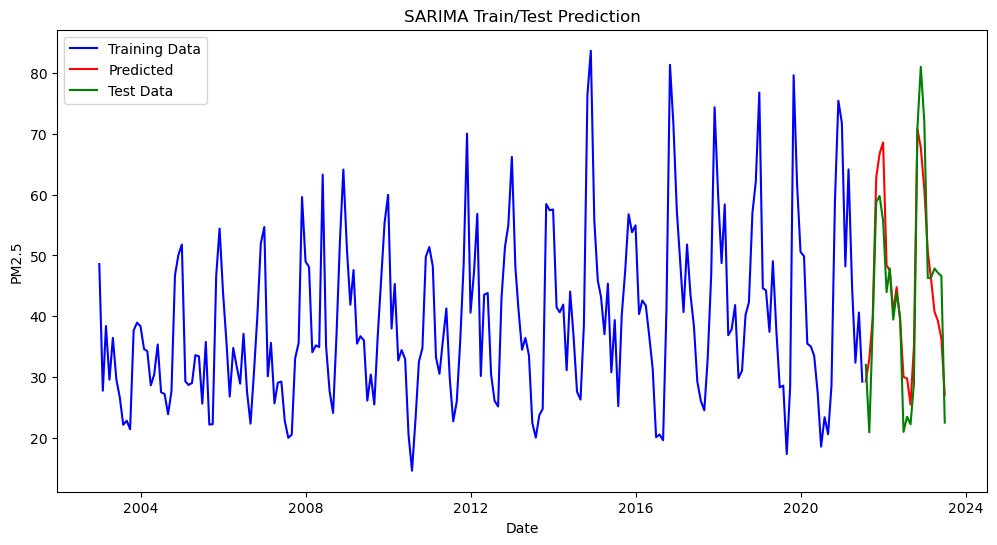

8.352526581417541


In [ ]:
time_series = pm.index  # Replace 'Date' with your date column
pm25_values = pm['pm2.5']  # Replace 'PM2.5' with your PM2.5 column

# Convert time series data to datetime index
time_series = pd.to_datetime(time_series)
p = pd.Series(pm25_values, index=time_series)

# Split data into training and testing sets
train_data = p[:-24]  # Use all data except the last 12 months for training
test_data = p[-24:]  # Use the last 12 months for testing

# Define SARIMA hyperparameters (you can adjust these as needed)
p = 3  # Autoregressive (AR) order
d = 1  # Integrated (I) order
q = 1  # Moving Average (MA) order
P = 3  # Seasonal AR order
D = 1  # Seasonal I order
Q = 2  # Seasonal MA order
s = 12  # Seasonal periodicity (e.g., for monthly data, s=12 for yearly s=1)

# Create the SARIMA model
sarima_model = sm.tsa.SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_results = sarima_model.fit()

# Make predictions on the test set
forecast_steps = len(test_data)
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
mse = ((sarima_results.resid) ** 2).mean()

# Plot the training data, predicted values, and test data
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Predicted', color='red')
plt.plot(test_data.index, test_data, label='Test Data', color='green')
plt.legend()
plt.title('SARIMA Train/Test Prediction')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.show()
print(mse ** (1/2))

<Figure size 1000x600 with 0 Axes>

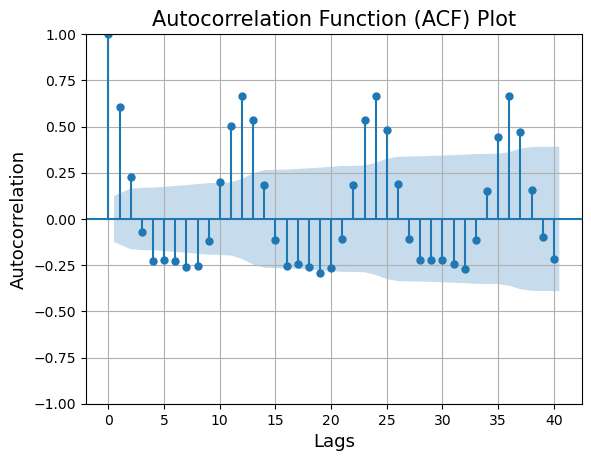

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming you have a time series in 'y'
# Replace 'y' with your actual time series data

# Create an ACF plot
plt.figure(figsize=(10, 6))
plot_acf(pm['pm2.5'], lags=40)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF) Plot', fontsize=15)
plt.xlabel('Lags', fontsize=13)
plt.ylabel('Autocorrelation', fontsize=13)
plt.grid()
plt.show()

## Forecasting

                                        SARIMAX Results                                        
Dep. Variable:                                   pm2.5   No. Observations:                  247
Model:             SARIMAX(3, 1, 1)x(2, 2, [1, 2], 12)   Log Likelihood                -794.888
Date:                                 Mon, 25 Sep 2023   AIC                           1607.775
Time:                                         11:11:51   BIC                           1638.399
Sample:                                     01-01-2003   HQIC                          1620.139
                                          - 07-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1617      0.074      2.171      0.030       0.016       0

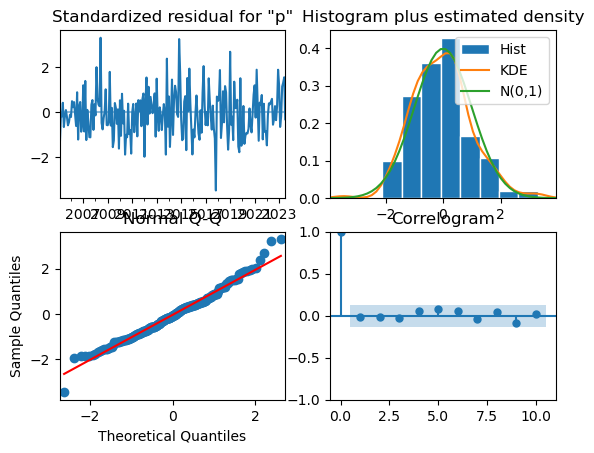

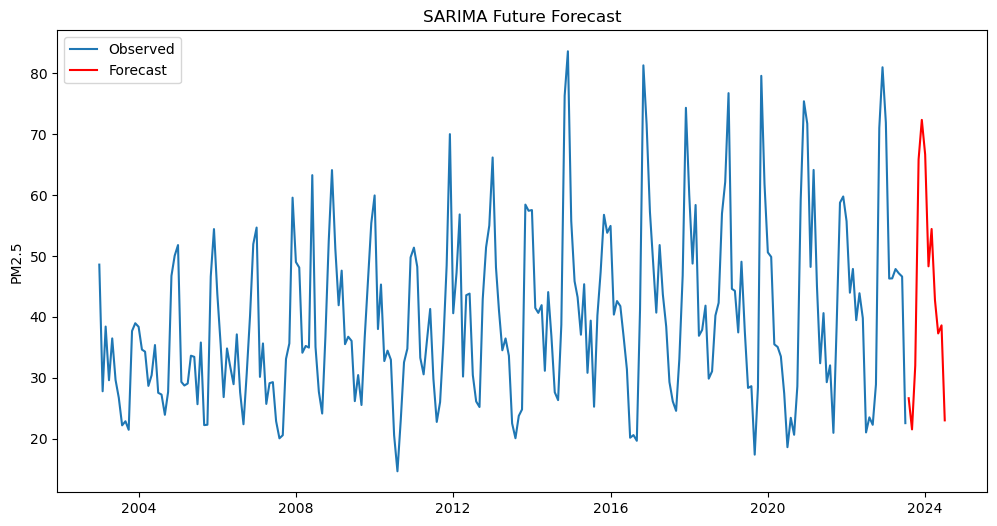

In [ ]:
# Define the SARIMA hyperparameters
p = 3  # Autoregressive (AR) order
d = 1  # Integrated (I) order
q = 1  # Moving Average (MA) order
P = 2  # Seasonal AR order
D = 2  # Seasonal I order
Q = 2  # Seasonal MA order
s = 12  # Seasonal periodicity (e.g., for monthly data, s=12 for yearly s=1)

# Create the SARIMA model
sarima_model = sm.tsa.SARIMAX(pm['pm2.5'], order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to your data
sarima_results = sarima_model.fit()

# Print a summary of the model
print(sarima_results.summary())

# Plot diagnostics to check for model adequacy
sarima_results.plot_diagnostics()
plt.show()

# Make predictions
forecast_steps = 12  # Number of steps ahead to forecast
forecast = sarima_results.get_forecast(steps=forecast_steps)

# Get the forecasted values and associated confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(pm.index, pm['pm2.5'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
#plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink')
plt.legend()
plt.title('SARIMA Future Forecast')
plt.ylabel('PM2.5')
plt.show()

In [ ]:
pm = xr.open_dataset(r'C:\Users\AnnaSaiNikhil\Downloads\Total Surface Mass Concentration - PM 2.5 monthly 0.5 x 0.625.nc')

In [ ]:
pm = pm.to_dataframe()

In [ ]:
pm.reset_index(drop = True, inplace = True)
pm = pm.drop('datamonth', axis = 1)
pm = pm[::2]
pm = pm.rename(columns = {'M2TMNXAER_5_12_4_TOTSMASS25' : 'pm2.5', 'time_bnds' : 'time'})
pm.set_index('time', inplace = True)
pm = pd.DataFrame(pm[:247])
pm['pm2.5'] = pm['pm2.5'] * 10 ** 9

In [ ]:
pm

,pm2.5
time,
2003-01-01,48.582850
2003-02-01,27.766492
2003-03-01,38.404126
2003-04-01,29.583028
2003-05-01,36.456843
...,...
2023-03-01,46.321432
2023-04-01,47.857254
2023-05-01,47.158392


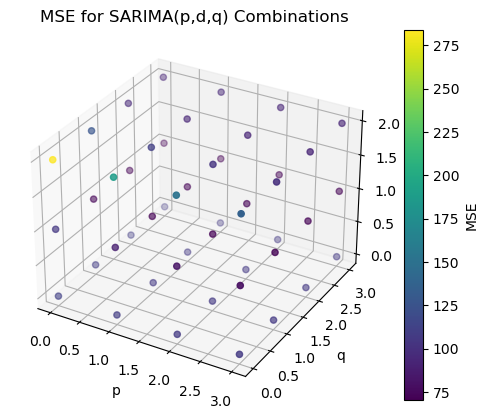

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of MSE values with a colorbar
scatter = ax.scatter(p_, q_, d_, c=mse_values, cmap='viridis')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('d')
ax.set_title('MSE for SARIMA(p,d,q) Combinations')

# Add a colorbar
colorbar = plt.colorbar(scatter, ax=ax, label='MSE')

# Show the plot
plt.show()

In [ ]:
mse_values

array([111.30012059, 108.72293138, 108.32732624, 107.51278454,
       104.64348151,  72.78847584,  71.2837488 ,  71.15040453,
       283.72380436, 126.46177952,  94.20876146,  92.94956071,
       108.22952578, 106.24288717, 106.13211603, 106.01829799,
        88.44740543,  71.11827153,  70.67009666,  71.28831391,
       188.36269394, 110.06798602,  92.77827163,  93.95041373,
       107.69398416, 106.1461715 , 106.04311895, 106.01469503,
        80.74037974,  70.98273828,  71.11858568,  70.4884515 ,
       151.51343685, 102.21544023,  92.61451712,  92.6088932 ,
       106.66782347, 106.028379  , 106.01647468, 106.01316837,
        77.9770969 ,  70.59724933,  70.4776776 ,  70.50688745,
       135.7887644 ,  99.24994463,  92.87662041,  92.46554182])

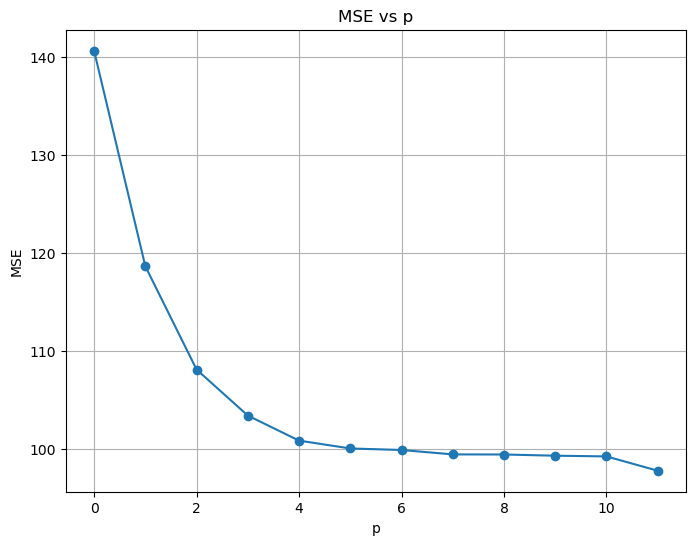

In [ ]:
ts_data = pm['pm2.5']

# Constants for d and q (you can adjust these as needed)
d = 1
q = 0

# Define a range of values for p
p_range = range(0, 14)  # Replace with your desired range of p values

# Create a list to store MSE values for different p values
mse_values = []

# Iterate through different values of p
for p in p_range:
    try:
        # Fit SARIMA model with constant d and q, and varying p
        sarima_model = sm.tsa.SARIMAX(ts_data, order=(p, d, q), seasonal_order=(2, 2, 2, 12))
        sarima_result = sarima_model.fit(disp=False)

        # Calculate MSE
        mse = ((sarima_result.resid) ** 2).mean()

        # Append MSE values to the list
        mse_values.append(mse)
    except:
        mse_values.append(np.nan)  # Handle cases where fitting fails

# Create a plot of MSE values vs. p
plt.figure(figsize=(8, 6))
plt.plot(p_range, mse_values, marker='o', linestyle='-')
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('MSE vs p')
plt.grid(True)
plt.show()

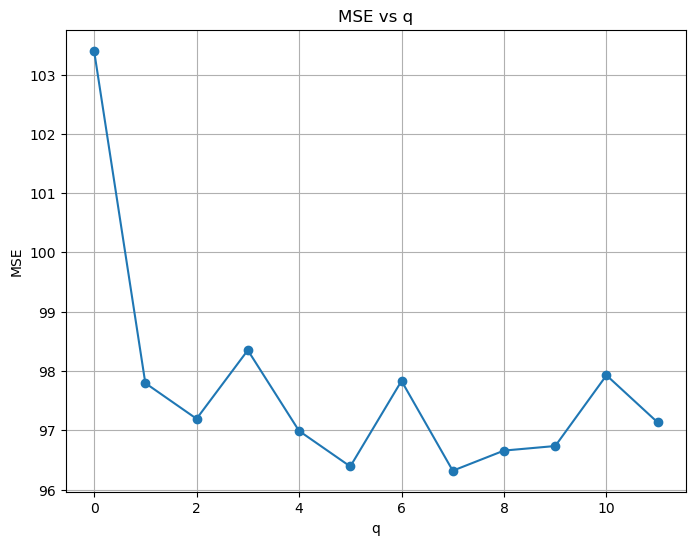

In [ ]:
ts_data = pm['pm2.5']

# Constants for d and q (you can adjust these as needed)
d = 1
p = 3

# Define a range of values for p
q_range = range(0, 14)  # Replace with your desired range of p values

# Create a list to store MSE values for different p values
mse_values = []

# Iterate through different values of p
for q in q_range:
    try:
        # Fit SARIMA model with constant d and q, and varying p
        sarima_model = sm.tsa.SARIMAX(ts_data, order=(p, d, q), seasonal_order=(2, 2, 2, 12))
        sarima_result = sarima_model.fit(disp=False)

        # Calculate MSE
        mse = ((sarima_result.resid) ** 2).mean()

        # Append MSE values to the list
        mse_values.append(mse)
    except:
        mse_values.append(np.nan)  # Handle cases where fitting fails

# Create a plot of MSE values vs. p
plt.figure(figsize=(8, 6))
plt.plot(p_range, mse_values, marker='o', linestyle='-')
plt.xlabel('q')
plt.ylabel('MSE')
plt.title('MSE vs q')
plt.grid(True)
plt.show()